# Convert your 2D CAD Drawing into 3D CAD Models
## Outline

This notebook is used for generating 3D CAD models given 3 views of the model, namely front, side and top view. 
## Dimensioning function
The following funtion is used for dimensioning step, where you have to provide the all the 3 views images and the output of this function will be the image highlighted with a line and the unit length to pixel value. Once you get the raito value you can multiple it with the length of the highlighted line to get the length to pixel ratio for that view.

In [1]:
class node:
    t = 0  # Translation has happened or not
    ro = 0  # Rotation has happened or not
    # Translation values
    tx = 0
    ty = 0
    tz = 0
    # Rotation values
    rx = 0
    ry = 0
    rz = 0

    def __init__(self, shape='set', operation='None',
                 l=0, b=0, h=0,
                 fn=12, fa=12, fs=2, r=0, r1=0,
                 center="true"):
        self.left = 'None'
        self.right = 'None'
        self.string = ''
        self.operation = operation
        self.shape = shape
        self.l = l
        self.b = b
        self.h = h
        self.fn = fn
        self.fa = fa
        self.fs = fs
        self.r = r  # Radius
        self.r1 = r1
        self.center = center

    def translate(self, x=0, y=0, z=0):
        self.tx = x
        self.ty = y
        self.tz = z
        self.t = 1

    def rotate(self, x=0, y=0, z=0):
        self.rx = x
        self.ry = y
        self.rz = z
        self.ro = 1

    def name(self):
        if(self.t == 1):
            self.string = 'translate([' + str(self.tx) + ',' + \
                str(self.ty) + ',' + str(self.tz) + ']){\n\t'
        if(self.ro == 1):
            if(self.t == 1):
                self.string = self.string + \
                    'rotate([' + str(self.rx) + ',' + str(self.ry) + \
                    ',' + str(self.rz) + ']){\n\t\t'
            else:
                self.string = self.string + \
                    'rotate([' + str(self.rx) + ',' + str(self.ry) + \
                    ',' + str(self.rz) + ']){\n\t'
        if(self.shape == "cube"):
            self.string = self.string + 'cube([' + str(self.l) + ',' + str(
                self.b) + ',' + str(self.h) + '], center = ' + self.center + ');\n'
        if(self.shape == "cylinder"):
            self.string = self.string + 'cylinder($fn = ' + str(self.fn) + ', h = ' + str(self.h) + ', r1 = ' + str(self.r) + \
                ', r2 = ' + str(self.r1) + ', center = ' + self.center + ');\n'
        if(self.shape == "sphere"):
            self.string = self.string + 'sphere($fn = ' + str(self.fn) + ', $fa = ' + str(self.fa) + ', $fs = ' + str(self.fs) + \
                'r = ' + str(self.r) + ');\n'
        if(self.ro == 1 and self.t == 1):
            self.string = self.string + "\t}\n"
        if(self.ro == 1 or self.t == 1):
            self.string = self.string + "}\n"

    def setr(self, r):
        self.r = r

    def setl(self, l):
        self.l = l

    def setb(self, b):
        self.b = b

    def seth(self, h):
        self.h = h

    def setr1(self, r):
        self.r1 = r

    def setoperation(self, operation):
        self.operation = operation

In [2]:
import cv2
import math

# Round up


def round_up(n, decimals=2):
    multiplier = 10 ** decimals
    n = math.ceil(n * multiplier) / multiplier
    return n

# To rearrange the parts in the views, like for front store all the parts such that the center of the shape is arranged in descending order of x pixel value
# otherwise do ascending order in side and top


def re_arrange(objects, type):
    if(type == "front"):
        objects.sort(key=lambda x: x[0][1][0], reverse=True)
    else:
        objects.sort(key=lambda x: x[0][1][0])


def draw_contour(img, out):
    # Converting into greyscale
    imgrey = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
    # COnverting into greyscale image to black and white image
    ret, thresh = cv2.threshold(imgrey, 127, 255, cv2.THRESH_BINARY_INV)
    # Finding contours
    contours, hierarchy = cv2.findContours(
        thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    # REarranging in descending order of area
    hierarchy, contours = zip(
        *sorted(zip(hierarchy[0], contours), key=lambda x: cv2.contourArea(x[1]), reverse=True))

    for i, c in enumerate(contours):

        if (hierarchy[i][3] != -1 or (hierarchy[i][3] == -1 and hierarchy[i][2] == -1)):
            M = cv2.moments(c)
            if(M["m00"] != 0):
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                area = cv2.contourArea(c)
                rect = cv2.minAreaRect(c)

                # Ignoring small areas
                # if(area <= 4):
                #     break

                # calculate coordinates of the minimum area rectangle
                box = cv2.boxPoints(rect)
                # draw the countour number on the image
                # cv2.putText(img, "#{}".format( i), (box[0][0], box[0][1]), cv2.FONT_HERSHEY_SIMPLEX,
                #     1.0, (255, 0, 0), 1)
                # draw contours
                cv2.drawContours(img, [c], 0, (0, 0, 255), 1)
    cv2.imwrite(out, img)


def add_part(objects, part, pos, type, ratio):

    # Translate based on the centers of the given shape with largest shape
    if(type == "front"):
        part[0].translate(round_up((part[1][0]-pos[0]) * ratio),
                          0, round_up((pos[1]-part[1][1]) * ratio))
    if(type == "side"):
        part[0].translate(0, round_up((part[1][0]-pos[0]) * ratio),
                          round_up((pos[1]-part[1][1]) * ratio))
    if(type == "top"):
        part[0].translate(round_up((part[1][1]-pos[1]) * ratio),
                          round_up((part[1][0]-pos[0]) * ratio), 0)

    # Search for the parent shape and place it inside that parent list
    for i, object in enumerate(objects):
        if(cv2.pointPolygonTest(object[0][2], part[1], False) >= 0):
            part[0].operation = "difference"
            #Adding in position
            object.append(part)
            return

    # If shape not found his parent, make a new list making it has parent
    objects.append([part])
    return


def combining(front_parts, side_parts, top_parts, roundOffApprox):
    # All the views are thought to be seen in y direction
    # For cube the "l" is length that is length of the rectangle/sqaure, "h" is height that is nothing but breadth of rectangle/sqaure,
    # "b" is the breath(thickness in y direction) of the cube
    # Cylinder will be upright position along z-axis(i.e when no ration is applied)

    # Looping through the Different parent child lists
    for i, front in enumerate(front_parts):
        first = 0
        # looping through all the parts of a parent and its child
        for j, part_f in enumerate(front):
            # part length is usually 5 - includes shape object,center,contour,height and width, if its six the shape is already considered and finalised
            if(len(part_f) >= 6):
                continue
            # Give the width of the parent to all its child when the parent is width found from side view
            if(first == 1):
                # If the child shape is cube
                if(part_f[0].shape == "cube"):
                    # Parent is also cube

                    if(front[0][0].shape == "cube"):
                        part_f[0].b = front[0][0].b
                    else:
                        part_f[0].b = front[0][0].h
                    # when the parent is rotated in z axis
                    if(front[0][0].rz != 0):
                        part_f[0].b = front[0][3]
                # If the child is cylinder
                if(part_f[0].shape == "cylinder"):
                    #Parent is cube
                    if(front[0][0].shape == "cube"):
                        part_f[0].h = front[0][0].b
                    else:
                        part_f[0].h = front[0][0].h
                    # when the parent is rotated in z axis
                    if(front[0][0].rz != 0):
                        part_f[0].h = front[0][3]
            # For checking whether the front shape is visible in side
            found = 0
            # Search side view
            for k, side in enumerate(side_parts):
                # For adding rest of the shapes in side view list, once a shape is found
                add_rest = 0
                for l, part_s in enumerate(side):
                    # ADD inner parts of side view only visible from side view and making sure the same shape is not added again once the shape is available in side view
                    if(add_rest == 1 and part_s[3] != -1):
                        # Increasing the size of parts list
                        part_s.append("used")
                        part_s[3] = -1
                        # Giving the x translation
                        part_s[0].tx = part_f[0].tx
                        # If the shape is cylinder give height to it
                        if(part_s[0].shape == "cylinder"):
                            part_s[0].h = part_f[4]
                        # If its a cube give breadth
                        elif(part_s[0].shape == "cube"):
                            part_s[0].b = part_f[4]
                        front.append(part_s)

                        continue
                    # check whether the height in front view is same in side view
                    if(abs(part_f[3]-part_s[3]) < roundOffApprox and found == 0):
                        # If the shape is found in side view
                        found = 1
                        # If its a parent in front view
                        if(j == 0):
                            first = 1
                        # If the side shape is not parent then its protruding, so make the operation as union
                        if(l != 0):
                            part_s[0].operation = "union"
                        # If Front view is cube
                        if(part_f[0].shape == "cube"):
                            # If side view is also cube
                            if(part_s[0].shape == "cube"):
                                # Check whether it is cylinder in top view or if there is any rotation in z-axis if the top view is also found to be cube

                                for top in top_parts:
                                    for m, part_t in enumerate(top):
                                        # Checking whether the shape is available in top view by comparing the height in top view
                                        # with the width in front view, as all the shapes are considered to be viewed in the direction of y-axis we need to compare
                                        # the height in top view with width in front view
                                        if(abs(part_t[3] - part_f[4]) < roundOffApprox and len(part_t) == 5):

                                            # If the shape in top view is child it must be protruding from it's parent to be visible in front view, so
                                            # we change the operation of the shape of the top view to union operation
                                            if(m != 0):
                                                part_t[0].operation = "union"
                                            # If it is a parent make the operation None
                                            if(j == 0):
                                                part_t[0].operation = "None"
                                            # If its a circle from top view replace the front view in "front_part" list with top view shape, while giving it a height
                                            #  and z-translate
                                            if(part_t[0].shape == "cylinder"):
                                                # Providing height and z-tranzlate for the shape in top view
                                                part_t[0].h = part_f[0].h
                                                part_t[0].tz = part_f[0].tz
                                                # Get to know the position of which parent we are adding in "front_part" so that the remaining shapes
                                                # in the top view after this shape can be added later into the "front_part" list
                                                part_t[1] = i
                                                # Marking that the shape in the top view is used
                                                part_t[2] = -1
                                                part_t.append("used")
                                                # Replace the shape in the front view by the shape obtained from top view
                                                part_f[0] = part_t[0]
                                                # Mark that the side view is used
                                                part_s[3] = -1
                                                # Giving signal to add rest of the child in side view after the current shape
                                                add_rest = 1
                                                break
                                            if(part_t[0].shape == "cube" and part_s[0].ry == 0 and part_f[0].ry == 0 and part_t[0].rz != 0 and abs(part_t[0].rz) != 90):
                                                # For the top view, cube will be rotated along x-axis so we need to provide them breadth rather
                                                #  than height
                                                part_t[0].b = part_f[0].h
                                                # Provide the z-translation from top view
                                                part_t[0].tz = part_f[0].tz
                                                # Get to know the position of which parent we are adding in "front_part" so that the remaining shapes
                                                # in the top view after this shape can be added later into the "front_part" list
                                                part_t[1] = i
                                                # Marking that the shape in the top view is used
                                                part_t[2] = -1
                                                part_t.append("used")
                                                # Replace the shape in the front view by the shape obtained from top view
                                                part_f[0] = part_t[0]
                                                # giving the thickness of the shape, helpful when the parent is rotated along z axis
                                                part_f[3] = part_t[3]
                                                # Mark that the side view is used
                                                part_s[3] = -1
                                                # Giving signal to add rest of the child in side view after the current shape
                                                add_rest = 1
                                                break
                                    else:
                                        # Using for else construct, which helps here to continue to traverse through the list until the shape is found in top view
                                        # or it exists from the top_part loop
                                        continue
                                    # Reaches here if counterpart for the front shape is in top view
                                    break
                            # If the shape was found in top view and we if we replaced with top view, then skip rest of the work below it
                            if(part_s[3] == -1):
                                continue

                            # If the side view is cylinder
                            if(part_s[0].shape == "cylinder"):
                                # Get height of the cylinder
                                part_s[0].h = part_f[0].l
                                # Get x-translation
                                part_s[0].tx = part_f[0].tx
                                # If the cube is front view cube is rotated along y axis
                                part_s[0].ry = part_f[0].ry
                                # Replace front view by side

                                if(j == 0):  # If it is a parent make the operation None
                                    part_s[0].operation = "None"

                                part_f[0] = part_s[0]
                                part_s[3] = -1
                                add_rest = 1
                                continue

                            # If the side view is cube
                            if(part_s[0].shape == "cube"):
                                # If the cube is rotated in front view i.e along y axis, then just provide the thickness and y translation
                                if(part_f[0].ry != 0 or part_s[0].ry == 0):
                                    part_f[0].b = part_s[0].l
                                    part_f[0].ty = part_s[0].ty
                                    part_s[3] = -1
                                    add_rest = 1
                                    continue
                                else:
                                    # Replacing front view by side view
                                    # thickness of the view
                                    part_s[0].b = part_f[0].l
                                    # x translation
                                    part_s[0].tx = part_f[0].tx
                                    # Replace front view by side view
                                    part_f[0] = part_s[0]
                                    part_s[3] = -1
                                    add_rest = 1
                                    continue

                        # If the shape in Front View is cylinder
                        if(part_f[0].shape == "cylinder"):
                            # If the side view is cube, which is obvious but still checking
                            if(part_s[0].shape == "cube"):
                                # The thickness/height for the cylinder is given by the length of the cube in side view(as side view shapes are rotated
                                # in 90 about z-axis) and also give the y-translation
                                part_f[0].h = part_s[0].l
                                part_f[0].ty = part_s[0].ty
                                # If the cube is rotated along x axis, by x axis rotation in side view is given by y axis as we are rotating the side view
                                # by 90 along z axis
                                part_f[0].rx = part_s[0].ry

                        # Side shape is used
                        part_s[3] = -1
                        # Add the rest of the shapes in side view for this parent/ this child's parent
                        add_rest = 1
                        continue
                # If the shape in front view is already found, dont check any other shapes in the next parent child list
                if(found == 1):
                    break

            # If the corresponding shape of the front view is not found in side view check in top view to get the thickness of the shape
            if(found == 0):
                # Search top view, here we are assuming
                for top in top_parts:
                    for m, part_t in enumerate(top):

                        # Checking whether the height of top view is same as width in front view and the top view shape should not be used before
                        if((abs(part_t[3]-part_f[4]) < roundOffApprox) and len(part_t) == 5):
                            # Experimental :- Check if the front shape is child, and x translation is too far - neglect same height in top and width in front which are of different shape
                            if(abs(part_f[0].tx - part_t[0].tx) > 0.5):
                                continue
                            # Checking whether the front view is a parent or not
                            if(j == 0):
                                first = 1
                            # If the shape in top view is child it must be protruding from it's parent to be visible in front view, so
                            # we change the operation of the shape of the top view to union operation
                            if(m != 0):
                                part_t[0].operation = "union"
                            # If it's a cylinder provide height and y-translation
                            if(part_f[0].shape == "cylinder"):
                                # This checking is not required as it is obvious, but still doing anyway
                                if(part_t[0].shape == "cube"):
                                    part_f[0].h = part_t[0].h
                                    part_f[0].ty = part_t[0].ty
                                    # If the cube is rotated in z axis
                                    part_f[0].rz = part_t[0].rz
                                    # For adding the rest of the child later give the top shape with height, z-translation and the position of the
                                    # "front_parts" we are comparing now
                                    part_t[0].b = part_f[3]
                                    part_t[0].tz = part_f[0].tz
                                    # Get to know the position of which parent we are adding in "front_part" so that the remaining shapes
                                    # in the top view after this shape can be added later into the "front_part" list
                                    part_t[1] = i
                                    # Marking that the shape in the top view is used
                                    part_t[2] = -1
                                    part_t.append("used")
                                    break

                            if(part_f[0].shape == "cube"):

                                part_t[0].tz = part_f[0].tz
                                if(part_t[0].shape == "cube"):
                                    part_t[0].b = part_f[0].h
                                    # Check whether the cube is rotated along z axis( in top view)
                                    if(part_t[0].rz != 0):
                                        part_f[0] = part_t[0]
                                    else:
                                        # Getting thickness for the front view, which is the length of the top view
                                        part_f[0].b = part_t[0].l
                                        part_f[0].ty = part_t[0].ty

                                elif(part_t[0].shape == " cylinder"):
                                    # If cube is rotated along y axis
                                    part_t[0].ry = part_f[0].ry
                                    part_t[0].h = part_f[0].h
                                    part_f[0] = part_t[0]

                                part_t[1] = j
                                # Marking that the shape in the top view is used
                                part_t[2] = -1
                                part_t.append("used")
                                break
                    else:
                        # Continue until you find the matching of front and top view
                        continue
                    break

    # Add the shape that is only visible in side view and top view(parent part and its child)
    for side in side_parts:
        # If the parent is not used, get the thickness from top view, we are not checking front view because all the shapes visible in front view
        # are already considered
        if(side[0][3] != -1):
            addCompleteList = []
            for part_s in side:
                # Looping through top view
                if(part_s[3] == -1):
                    break

                for k, top in enumerate(top_parts):
                    for l, part_t in enumerate(top):
                        # Check whether their width are same in both side and top view and top view should not be used already
                        if((abs(part_s[4]-part_t[4]) < roundOffApprox) and len(part_t) == 5):

                            if(part_s[0].shape == "cube"):
                                # Giving z-translation
                                part_t[0].tz = part_s[0].tz
                                if(part_t[0].shape == "cube"):
                                    # Giving thickness to top view shape
                                    part_t[0].b = part_s[0].h
                                    # Check whether the cube is rotated along z axis( in top view)
                                    if(part_t[0].rz != 0):
                                        part_s[0] = part_t[0]
                                    else:
                                        # Getting thickness for the front view
                                        part_s[0].b = part_t[0].h
                                        # Give x-translation
                                        part_s[0].tx = part_t[0].tx

                                elif(part_t[0].shape == " cylinder"):
                                    # Rotated along x axis, but as we have rotated the side view along z axis to 90, we use ry of side view
                                    part_t[0].rx = part_s[0].ry
                                    part_t[0].h = part_s[0].h
                                    part_s[0] = part_t[0]

                                # Getting the location of the parent-child side view we are going to add to "front_parts"
                                part_t[1] = len(front_parts)
                                # Marking that the shape in the top view is used
                                part_t[2] = -1
                                part_t.append("used")
                            # If its a cylinder get its height
                            if(part_s[0].shape == "cylinder"):
                                # This checking is not required as it is obvious, but still doing anyway
                                if(part_t[0].shape == "cube"):
                                    # Get height
                                    part_s[0].h = part_t[0].h
                                    # Give x-translation
                                    part_s[0].tx = part_t[0].tx
                                    # Rotation in z axis
                                    part_s[0].rz = part_t[0].rz
                                    # For adding the rest of the child later give the top shape with height, z-translation and the position of the
                                    # "front_parts" we are comparing now
                                    part_t[0].b = part_s[3]
                                    part_t[0].tz = part_s[0].tz
                                    # Get to know the position of which parent we are adding in "front_part" so that the remaining shapes
                                    # in the top view after this shape can be added later into the "front_part" list
                                    part_t[1] = len(front_parts)
                                    # Marking that the shape in the top view is used
                                    part_t[2] = -1
                                    part_t.append("used")
                addCompleteList.append(part_s)
            # Append whole parent-child list into "front_parts"
            front_parts.append(addCompleteList)

    # Add shapes only visible in top
    for top in top_parts:
        # Need to give the top view heights
        height = -1
        # For z-translation
        tz = -1
        # Position of the parent-child list where we need to add, which is stores in part list earlier
        position = -1
        # Loop through parent-child list to first find the position of the shape which is used while comparing with front view
        for part_t in top:
            # Check whether the height of the used shape is given and also check whether the shape in top view is already used
            if(height != -1 and len(part_t) == 5):
                # If its a cylinder provide height and z-translation
                if(part_t[0].shape == "cylinder"):
                    part_t[0].h = height
                    part_t[0].tz = tz
                # If its a cube provide breadth(as the cube is rotated along x axis in top view) and z-translation
                elif (part_t[0].shape == "cube"):
                    part_t[0].b = height
                    part_t[0].tz = tz
                # Appending the shape in front_parts in the position obtained from previous top shape
                try:
                    front_parts[position].append(part_t)
                except:
                    print("Error occurred")
            # Check if the given top view is used
            try:
                class Spam(int):
                    pass
                if(isinstance(Spam(part_t[2]), int)):
                    # Store its z-translation
                    tz = part_t[0].tz
                    # Get the position in front_parts list to add the rest of the child shape
                    position = part_t[1]
                    # Getting the height of the top shape already used, for cube its given by breadth, for cylinder, it is it's height
                    if(part_t[0].shape == "cylinder"):
                        height = part_t[0].h
                    elif (part_t[0].shape == "cube"):
                        height = part_t[0].b
            except TypeError:
                pass

    return front_parts


def detect(c):
    # initialize the shape name and approximate the contour
    shape = "unidentified"
    peri = cv2.arcLength(c, True)
    # Finding the number of line segment required to make the polygon
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # Cylinder type in openscad for making regular prism
    cylinder_type = 0

    # if the shape is a triangle, it will have 3 vertices
    if len(approx) == 3:
        shape = "triangle"
        cylinder_type = 3
    # if the shape has 4 vertices, it is either a square or a rectangle
    elif len(approx) == 4:
        # compute the bounding box of the contour and use the
        # bounding box to compute the aspect ratio
        (x, y, w, h) = cv2.boundingRect(approx)
        ar = w / float(h)
        rect = cv2.minAreaRect(c)
        ar = rect[1][0] / float(rect[1][1])
        # a square will have an aspect ratio that is approximately
        # equal to one, otherwise, the shape is a rectangle
        shape = "square" if ar >= 0.999 and ar <= 1.001 else "rectangle"

    # if the shape is a pentagon, it will have 5 vertices
    elif len(approx) == 5:
        shape = "pentagon"
        cylinder_type = 5
    # if the shape is a hexagon, it will have 6 vertices
    elif len(approx) == 6:
        shape = "hexagon"
        cylinder_type = 6
    # otherwise, we assume the shape is a circle
    else:
        shape = "circle"
        cylinder_type = 1

    # return the name of the shape
    return shape, cylinder_type


def valid_contours(img, type, ratio):
    # List to build parent and child shapes
    objects = []
    # Converting into greyscale
    imgrey = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
    # COnverting into greyscale image to black and white image
    ret, thresh = cv2.threshold(imgrey, 127, 255, cv2.THRESH_BINARY_INV)
    # Finding contours
    contours, hierarchy = cv2.findContours(
        thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    # Rearranging such that the contours are arranged in descending order
    hierarchy, contours = zip(
        *sorted(zip(hierarchy[0], contours), key=lambda x: cv2.contourArea(x[1]), reverse=True))

    # Looping through all contours
    for i, c in enumerate(contours):
        # Choosing inner side of the two same shape created by thickness of the line
        if (hierarchy[i][3] != -1 or (hierarchy[i][3] == -1 and hierarchy[i][2] == -1)):
            M = cv2.moments(c)
            if(M["m00"] != 0):
                # Getting the center of the contour
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                # Getting Contour area
                area = cv2.contourArea(c)
                # Rescaling based on input from user
                area = area * ratio
                # getting minimum area rectangle that is enclosing the contour
                rect = cv2.minAreaRect(c)
                # Ignoring small areas
                if(area <= 4*ratio):
                    break
                # calculate coordinates of the minimum area rectangle
                box = cv2.boxPoints(rect)
                # Rescaling based on input from user
                rectLength = round_up(rect[1][0] * ratio)
                rectBreadth = round_up(rect[1][1] * ratio)

                # it's a horizontal rectangle which encloses the contour
                x, y, w, h = cv2.boundingRect(c)
                w = round_up(w * ratio)
                h = round_up(h * ratio)
                # Making largest contour's center has reference for translation of other shape
                if(len(objects) == 0):
                    pos = [cX, cY]

                # draw the contour number on the image
                # cv2.putText(img, "#{}".format(i), (box[0][0], box[0][1]), cv2.FONT_HERSHEY_SIMPLEX,
                #     1.0, (255, 0, 0), 1)
                # draw contours
                cv2.drawContours(img, [c], 0, (0, 0, 255), 1)
                # Detecting the shape of the contour
                shape, cylinder_type = detect(c)

                # To store the shape and its details
                part = []

                if(shape == "square"):
                    # Adding shape
                    part.append(node(shape="cube", l=rectLength,
                                     b=rectLength, h=rectLength))
                    # Giving rotatation
                    if(type == "front"):
                        part[0].rotate(0, rect[2], 0)
                    elif(type == "side"):
                        part[0].rotate(0, rect[2], 90)
                    elif(rect[2] == 0):
                        part[0].rotate(90, 0, 90)
                    else:
                        part[0].rotate(90, 0, rect[2])

                    # Adding center of the contour
                    part.append(tuple([cX, cY]))
                    # Adding contour
                    part.append(c)
                    # Adding height of the horizontal rectangle enclosing the contour
                    part.append(h)
                    # Adding width of the horizontal rectangle enclosing the contour
                    part.append(w)
                    # Adding to the list of shape in parent child manner
                    add_part(objects, part, pos, type, ratio)
                elif(shape == "rectangle"):
                    if(type == "front"):
                        if(rect[2] == -90):
                            part.append(
                                node(shape="cube", l=rectBreadth, b=rectBreadth, h=rectLength))
                            part[0].rotate(0, 0, 0)
                        else:
                            part.append(
                                node(shape="cube", l=rectLength, b=rectLength, h=rectBreadth))
                            part[0].rotate(0, rect[2], 0)
                    elif(type == "side"):
                        if(rect[2] == -90):
                            part.append(
                                node(shape="cube", l=rectBreadth, b=rectBreadth, h=rectLength))
                            part[0].rotate(0, 0, 90)
                        else:
                            part.append(
                                node(shape="cube", l=rectLength, b=rectLength, h=rectBreadth))
                            part[0].rotate(0, rect[2], 90)
                    # If there is no rotation in top view rotate 90 along in both x and z axis
                    elif(rect[2] == -90):
                        part.append(node(shape="cube", l=rectBreadth,
                                         b=rectBreadth, h=rectLength))
                        part[0].rotate(90, 0, 90)
                    elif(rect[2] == 0):
                        part.append(node(shape="cube", l=rectLength,
                                         b=rectLength, h=rectBreadth))
                        part[0].rotate(90, 0, 90)
                    else:
                        # If there is some rotation, rotate in z axis
                        part.append(node(shape="cube", l=rectLength,
                                         b=rectLength, h=rectBreadth))
                        part[0].rotate(90, 0, rect[2])

                    part.append(tuple([cX, cY]))
                    part.append(c)
                    part.append(h)
                    part.append(w)
                    add_part(objects, part, pos, type, ratio)
                # Cylinder type in openscad
                elif(cylinder_type > 0):
                    # Cylinder
                    if(shape == "circle"):
                        _, radius = cv2.minEnclosingCircle(c)
                        radius = round_up(radius * ratio)
                        part.append(
                            node(shape="cylinder", r=radius, r1=radius, h=rectLength))
                        if(type == "front"):
                            part[0].rotate(90, 0, 0)
                        elif(type == "side"):
                            part[0].rotate(0, 90, 0)
                        part.append(tuple([cX, cY]))
                        part.append(c)
                        part.append(h)
                        part.append(w)
                        add_part(objects, part, pos, type, ratio)
                    else:
                        # Regular prism
                        _, radius = cv2.minEnclosingCircle(c)
                        radius = round_up(radius * ratio)
                        part.append(node(shape="cylinder", r=radius,
                                         r1=radius, h=rectLength, fn=cylinder_type))
                        if(type == "front"):
                            part[0].rotate(90, -90 - rect[2], 0)
                        elif(type == "side"):
                            part[0].rotate(0, 90, 0)
                        else:
                            part[0].rotate(0, 0, rect[2])
                        part.append(tuple([cX, cY]))
                        part.append(c)
                        part.append(h)
                        part.append(w)
                        add_part(objects, part, pos, type, ratio)
                else:
                    print("shape not detected")
    # cv2.imwrite("result1"+type+".png",img)
    return objects


In [3]:
def writetofile(filename, string):
    file = open(filename, "a")
    file.write(string)
    file.close()


def createtree(nodes, filename):
    if(len(nodes) == 0):
        print("No shapes detected")
        return

    subtree = []
    string = ''
    # Initialize empty node
    present = node()
    # Add the first node in left child
    present.left = nodes[0]
    # Generates function/string for the shape as in openscad
    nodes[0].name()
    # Add the generated string to the present node
    present.string = nodes[0].string
    # If there is only one node, write it to the file
    if(len(nodes) == 1):
        writetofile(filename, present.string)
    # If the number of nodes is more than one enter the loop
    for i, object in enumerate(nodes[1:]):
        # Generate function/statement for the shape as in openscad
        object.name()
        # If Node is child of shapes
        if(object.operation != 'None'):
            # If the right child in tree is free
            if(present.right == 'None'):
                # Assign the right parent
                present.right = object
                # Update the present string
                present.string = object.operation + \
                    "() {\n\t" + present.string + \
                    '\n\t' + object.string + '}\n'
                # Store it for appending into the file
                string = present.string
            else:
                # If right is not free, create a new node and make the present node as left child to the new node
                temp = present
                present = node()
                present.left = temp
                present.string = temp.string
                # Then make the object as right child of the new node
                present.right = object
                # Update the string
                present.string = object.operation + \
                    "() {\n\t" + present.left.string + \
                    '\n\t' + object.string + '}\n'
                # Store it for appending
                string = present.string
        else:
            # Satisfies this condition only when there is two consecutive parent shape with no child
            if(present.right == 'None'):
                # Append the present string to the file
                writetofile(filename, present.string)

            # So as parent-child list is completly traversed, it is added to subtree and the subtree string is appended to the file
            subtree.append(present)
            writetofile(filename, string)
            # Create a new subtree
            string = ''
            present = node()
            present.left = object
            present.string = object.string
            # If the last node is the parent shape node
            if(i == len(nodes)-2):
                writetofile(filename, present.string)
    # If the last node is a child shape node
    if(string != ''):
        writetofile(filename, string)
    # Add the last subtree
    subtree.append(present)
    print("Subtree:", len(subtree))


In [4]:
import copy
import json
import os
import shutil
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image


def Dimensioning(view,image):

    #Creating temp directory if not present
    #os.makedirs('static/temp', exist_ok=True)
    #Getting user input from app
    img = cv2.imread(image,cv2.IMREAD_UNCHANGED)
    #Initialization
    ratio = 0
    shape = "unidentified"
    #Getting the size of image
    try:
        w,h,_=img.shape
        drawSize = int(h/300)
        # if(drawSize == 0):
        #     drawSize = 1
        #Convert image to grayscale
        imgrey = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
        #Convert image to black and white
        ret, thresh = cv2.threshold(imgrey,127,255,cv2.THRESH_BINARY_INV)
        #Find contours
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
        #Arrange the contours in descending order of area
        hierarchy,contours = zip(*sorted(zip(hierarchy[0],contours),key = lambda x: cv2.contourArea(x[1]),reverse=True))

        for i,c in enumerate(contours):
            #Get the outer most closed contour
            if(hierarchy[i][3] != -1  or (hierarchy[i][3] == -1 and hierarchy[i][2] == -1) ):
                M = cv2.moments(c)
                if(M["m00"] !=0):
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    #Getting the minimum area rectangle enclosing the contour
                    rect = cv2.minAreaRect(c)
                    box = cv2.boxPoints(rect)
                    box = np.int0(box)
                    #Getting horizontal rectangle enclosing the contour
                    x,y,w,h = cv2.boundingRect(c)

                    # cv2.putText(img, "#{}".format(i), (box[0][0], box[0][1]), cv2.FONT_HERSHEY_SIMPLEX,
                    #     textSize, (255, 0, 0), drawSize,cv2.LINE_AA)

                    #detect Shape
                    shape, cylinder_type = detect(c)              
                    if(shape == "unidentified"):
                        continue

                    if(shape=="triangle" or shape=="pentagon" or shape=="hexagon"):
                        img = cv2.drawContours(img, [box], 0, (0,0, 255), drawSize)
                    # w is the width of the rectagle enclosing the circle, i.e diameter of the circle
                    if(shape=="circle"):
                        # draw contours
                        img = cv2.rectangle(img,(x,y),(x+w,y+h),(0, 0, 255),drawSize)
                        cv2.line(img, (x,y), (x+w,y), (0,255, 0), 2)
                        ratio = 1/w
                    else:
                        # draw contours
                        # img = cv2.drawContours(img, [box], 0, (0,0, 255), drawSize)
                        cv2.line(img, tuple(box[0]), tuple(box[1]), (0,255, 0), 2)
                        #Length per pixel
                        ratio = 1.0/rect[1][1]
                    break

        
        ratio = str(ratio)
        data={'ratio': ratio}

        return data
    except:
      print(view + "image not found")

## Converting function
This takes in all the 3 images and the length to pixel ratio for each view and created the 3D scad Model. ALso provide the unique userId which will be used to name the final scad file. you can see all the results in static folder

In [5]:
import time

def Convert(front_image, side_image, top_image, fratio, sratio, tratio, path_file):
    # store starting time 
    start = time.time() 

    img_front = cv2.imread(front_image,cv2.IMREAD_UNCHANGED)
    img_side = cv2.imread(side_image,cv2.IMREAD_UNCHANGED)
    img_top = cv2.imread(top_image,cv2.IMREAD_UNCHANGED)

    fratio = float(fratio)
    sratio = float(sratio)
    tratio = float(tratio)

    primitive = []

    object_front = valid_contours(img_front,"front",fratio)
    re_arrange(object_front,"front")
    
    object_side = valid_contours(img_side,"side",sratio)
    re_arrange(object_side,"side")

    object_top = valid_contours(img_top,"top",tratio)
    re_arrange(object_top,"top")

    minApprox = 0.05
    primitive = combining(object_front,object_side,object_top,minApprox)
    final = []
    for set in primitive:
        for shape in set:
            final.append(shape[0])
    

    createtree(final,path_file)

    end = time.time() 
    print("Total time taken to convert:",end-start)
    return path_file


## Sample run
Setting the image fiel path 

In [6]:
front_image = '00000003_f.png'
side_image = '00000003_r.png'
top_image = '00000003_t.png'
front_image

'00000003_f.png'

In [7]:
import os

# Получение текущей рабочей директории
current_directory = os.getcwd()

print(f"Текущая директория: {current_directory}")

Текущая директория: c:\Users\Maksim\Desktop\Хакатонs\AIIngeneer\Задача1\Photo2CAD


In [166]:
# import subprocess
# command = ["openscad", "-o", output_stl, input_scad]
# try:
#     # Запуск команды
#     subprocess.run(command, check=True)
#     print(f"Файл успешно конвертирован: {output_stl}")
# except subprocess.CalledProcessError:
#     print("Ошибка при конвертации SCAD в STL.")

In [8]:
from os import listdir
from os.path import isfile, join
mypath = "CSG_data_PNG/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and f.lower().endswith('.png')]
uniq_files = list(set([f[:-5] for f in onlyfiles]))
ideal = []
for f in uniq_files:
    for s in ['f', 'r', 't']:
        ideal.append(f"{f}{s}.png")
depricated = set(set(ideal) - set(onlyfiles))
depricated = list(set([f[:-5] for f in depricated]))

In [9]:
import cv2
import numpy as np

def remove_red_pixels(image_path):
    # Загружаем изображение
    image = cv2.imread(image_path)
    
    # Преобразуем в формат HSV (для лучшего определения красного цвета)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Определяем диапазон красного цвета в HSV
    # Первый диапазон для красного цвета (0-10)
    lower_red_1 = np.array([0, 100, 100])
    upper_red_1 = np.array([10, 255, 255])

    # Второй диапазон для красного цвета (170-180)
    lower_red_2 = np.array([170, 100, 100])
    upper_red_2 = np.array([180, 255, 255])

    # Находим пиксели, которые соответствуют красному цвету
    mask1 = cv2.inRange(hsv, lower_red_1, upper_red_1)
    mask2 = cv2.inRange(hsv, lower_red_2, upper_red_2)
    mask = cv2.bitwise_or(mask1, mask2)

    # Находим все пиксели, которые не черные
    non_black_mask = np.any(image != [0, 0, 0], axis=-1)

    # Заменяем все пиксели, которые не черные, на белые
    image[non_black_mask] = [255, 255, 255]

    # Сохраняем измененное изображение
    return image

In [10]:
# Функция для применения remove_red_pixels и сохранения изображений
def process_and_save_images(front_image_path, side_image_path, top_image_path, output_dir):
    # Создаем папку, если её не существует
    os.makedirs(output_dir, exist_ok=True)
    
    # Применяем remove_red_pixels и сохраняем изображения
    front_image_no_red = remove_red_pixels(front_image_path)
    side_image_no_red = remove_red_pixels(side_image_path)
    top_image_no_red = remove_red_pixels(top_image_path)

    # Формируем пути для сохранения изображений
    front_image_output = os.path.join(output_dir, os.path.basename(front_image_path))
    side_image_output = os.path.join(output_dir, os.path.basename(side_image_path))
    top_image_output = os.path.join(output_dir, os.path.basename(top_image_path))

    # Сохраняем измененные изображения
    cv2.imwrite(front_image_output, front_image_no_red)
    cv2.imwrite(side_image_output, side_image_no_red)
    cv2.imwrite(top_image_output, top_image_no_red)
    
    return front_image_output, side_image_output, top_image_output

# Основной цикл
output_dir = "NoRedTestDrafts"

In [11]:
def executor(front_image, side_image, top_image, scad_path):
    d1 = Dimensioning("front",front_image)
    d2 = Dimensioning("side",side_image)
    d3 = Dimensioning("top",top_image)
    fratio = float(d1["ratio"]) * 2 #Width of rectangle in highlighted in front view 
    sratio = float(d2["ratio"]) * 3 #Width of rectangle in highlighted in front view
    tratio = float(d3["ratio"]) * 1.73 #Width of rectangle in highlighted in front view
    Convert(front_image, side_image, top_image,fratio, sratio, tratio, scad_path)
    
    

In [180]:
for f in uniq_files:
    if f not in depricated:
        front_image, side_image, top_image = '', '', ''
        paths = []
        for s in ['f', 'r', 't']:
            paths.append(f"CSG_data_PNG/{f}{s}.png")
        front_image, side_image, top_image = paths
        scad_path = f"Models/{f[:-1]}.scad"
        executor(front_image, side_image, top_image, scad_path)

C:\Users\Maksim\AppData\Local\Temp\ipykernel_16452\2882067752.py:45: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


Subtree: 16
Total time taken to convert: 0.010964155197143555
Subtree: 23
Total time taken to convert: 0.013001441955566406
Subtree: 21
Total time taken to convert: 0.010959148406982422
Subtree: 15
Total time taken to convert: 0.007000923156738281
Subtree: 9
Total time taken to convert: 0.0050008296966552734
Subtree: 3
Total time taken to convert: 0.003964900970458984
Subtree: 9
Total time taken to convert: 0.005000114440917969
Subtree: 11
Total time taken to convert: 0.004999399185180664
Subtree: 18
Total time taken to convert: 0.00700068473815918
Subtree: 7
Total time taken to convert: 0.0039997100830078125
Subtree: 12
Total time taken to convert: 0.006000518798828125
Subtree: 17
Total time taken to convert: 0.00799870491027832
Subtree: 8
Total time taken to convert: 0.0049991607666015625
Subtree: 7
Total time taken to convert: 0.003999948501586914
Subtree: 2
Total time taken to convert: 0.0019989013671875
Subtree: 3
Total time taken to convert: 0.0019996166229248047
Subtree: 6
Total

In [176]:
for f in uniq_files:
    if f not in depricated:
        front_image, side_image, top_image = '', '', ''
        paths = []
        for s in ['f', 'r', 't']:
            paths.append(f"../test_drafts/PNG/{f}{s}.png")
        
        # Обработка и сохранение изображений с удалением красных пикселей
        front_image, side_image, top_image = process_and_save_images(paths[0], paths[1], paths[2], output_dir)

        # Путь к SCAD файлу
        scad_path = f"Test_noRed_Models_SCAD/{f[:-1]}.scad"

        # Вызов executor с новыми путями
        executor(front_image, side_image, top_image, scad_path)

C:\Users\Maksim\AppData\Local\Temp\ipykernel_16452\2882067752.py:45: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


Subtree: 9
Total time taken to convert: 0.007001399993896484
Subtree: 7
Total time taken to convert: 0.007999181747436523
Subtree: 8
Total time taken to convert: 0.005999326705932617
Subtree: 9
Total time taken to convert: 0.005975961685180664
Subtree: 7
Total time taken to convert: 0.0039997100830078125
Subtree: 12
Total time taken to convert: 0.007042646408081055
Subtree: 3
Total time taken to convert: 0.0029990673065185547
Subtree: 7
Total time taken to convert: 0.004999399185180664
Subtree: 9
Total time taken to convert: 0.005000591278076172
Subtree: 16
Total time taken to convert: 0.008000612258911133
Subtree: 4
Total time taken to convert: 0.0030007362365722656
Subtree: 11
Total time taken to convert: 0.005999088287353516
Subtree: 7
Total time taken to convert: 0.005008220672607422
Subtree: 14
Total time taken to convert: 0.00671839714050293
Subtree: 7
Total time taken to convert: 0.005244731903076172
Subtree: 3
Total time taken to convert: 0.003000020980834961
Subtree: 7
Total t

In [12]:
mypath = "Models"
onlyfiles = [f[:-5] for f in listdir(mypath) if isfile(join(mypath, f)) and f.lower().endswith('.scad')]

In [11]:
import os
import subprocess
def scad_to_stl(input_scad, output_stl):
    # input_scad = "Test_Models/00011251.scad"
    # output_dir = "Test_Models_STL"
    # output_stl = os.path.join(output_dir, "00011251.stl")

    openscad_path = "openscadExec\openscad.exe"
    command = [openscad_path, "-o", output_stl, input_scad]

    try:
        subprocess.run(command, check=True)
        print(f"Файл успешно конвертирован: {output_stl}")
    except FileNotFoundError:
        print("OpenSCAD не найден. Укажите правильный путь.")
    except subprocess.CalledProcessError:
        print("Ошибка при конвертации SCAD в STL.")

In [12]:
onlyfiles

['00000000',
 '00000001',
 '00000002',
 '00000003',
 '00000004',
 '00000005',
 '00000006',
 '00000007',
 '00000008',
 '00000010',
 '00000011',
 '00000012',
 '00000013',
 '00000014',
 '00000015',
 '00000016',
 '00000017',
 '00000018',
 '00000019',
 '00000021',
 '00000022',
 '00000023',
 '00000024',
 '00000025',
 '00000027',
 '00000028',
 '00000029',
 '00000030',
 '00000031',
 '00000032',
 '00000033',
 '00000034',
 '00000035',
 '00000036',
 '00000037',
 '00000038',
 '00000039',
 '00000040',
 '00000041',
 '00000042',
 '00000043',
 '00000044',
 '00000045',
 '00000046',
 '00000047',
 '00000048',
 '00000049',
 '00000050',
 '00000051',
 '00000052',
 '00000053',
 '00000054',
 '00000055',
 '00000056',
 '00000057',
 '00000058',
 '00000059',
 '00000060',
 '00000061',
 '00000062',
 '00000063',
 '00000064',
 '00000065',
 '00000066',
 '00000067',
 '00000068',
 '00000069',
 '00000070',
 '00000071',
 '00000072',
 '00000073',
 '00000074',
 '00000075',
 '00000076',
 '00000077',
 '00000078',
 '00000080',

In [13]:
for f in onlyfiles:
    input_scad = f"Models/{f}.scad"
    output_stl = f"ModelsSTL/{f}.stl"
    scad_to_stl(input_scad, output_stl)

Файл успешно конвертирован: ModelsSTL/00000000.stl
Файл успешно конвертирован: ModelsSTL/00000001.stl
Файл успешно конвертирован: ModelsSTL/00000002.stl
Файл успешно конвертирован: ModelsSTL/00000003.stl
Файл успешно конвертирован: ModelsSTL/00000004.stl
Файл успешно конвертирован: ModelsSTL/00000005.stl
Файл успешно конвертирован: ModelsSTL/00000006.stl
Файл успешно конвертирован: ModelsSTL/00000007.stl
Файл успешно конвертирован: ModelsSTL/00000008.stl
Файл успешно конвертирован: ModelsSTL/00000010.stl
Файл успешно конвертирован: ModelsSTL/00000011.stl
Файл успешно конвертирован: ModelsSTL/00000012.stl
Файл успешно конвертирован: ModelsSTL/00000013.stl
Файл успешно конвертирован: ModelsSTL/00000014.stl
Файл успешно конвертирован: ModelsSTL/00000015.stl
Файл успешно конвертирован: ModelsSTL/00000016.stl
Файл успешно конвертирован: ModelsSTL/00000017.stl
Файл успешно конвертирован: ModelsSTL/00000018.stl
Файл успешно конвертирован: ModelsSTL/00000019.stl
Файл успешно конвертирован: Mod

: 

Calling Dimensioning function for front view

In [90]:
d1 = Dimensioning("front",front_image)
print(front_image)
d1

frontimage not found
00000003_f.png


C:\Users\Maksim\AppData\Local\Temp\ipykernel_16452\2882067752.py:45: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


Calling Dimensioning function for side view

In [ ]:
d2 = Dimensioning("side",side_image)
d2

C:\Users\Maksim\AppData\Local\Temp\ipykernel_19276\1909849040.py:45: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


{'ratio': '0.007575757575757576'}

Calling Dimensioning function for top view

In [ ]:
d3 = Dimensioning("top",top_image)
d3

C:\Users\Maksim\AppData\Local\Temp\ipykernel_19276\1909849040.py:45: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


{'ratio': '0.007874016694078424'}

Multiply the ratio provided in the dimensioning step with the highlighted length

This is done because lets say the images are taken from camera the the pixel to dimension ratio
might changes for each view, so we take the pixel to dimension ratio for converions

In [118]:

fratio = float(d1["ratio"]) * 2 #Width of rectangle in highlighted in front view 
sratio = float(d2["ratio"]) * 3 #Width of rectangle in highlighted in front view
tratio = float(d3["ratio"]) * 1.73 #Width of rectangle in highlighted in front view

In [119]:
sratio

0.022727272727272728

In [120]:
fratio

0.012987012987012988

In [121]:
stl_filename = userId + '/' + userId + ".stl"

Call the function to convert the images to 3D scad model and the file path for scad is provided as output

In [1]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
%pip install "git+https://github.com/facebookresearch/pytorch3d.git@stable"

: 

In [ ]:
import os
import torch
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.ops import box3d_overlap

def get_bounding_box(mesh):
    """
    Извлекает bounding box (ограничивающий параллелепипед) из 3D-модели.
    """
    verts = mesh.verts_packed()  # Все вершины
    min_coords = verts.min(dim=0).values
    max_coords = verts.max(dim=0).values
    
    # Строим 8 вершин bounding box
    bbox = torch.tensor([
        [min_coords[0], min_coords[1], min_coords[2]],
        [max_coords[0], min_coords[1], min_coords[2]],
        [max_coords[0], max_coords[1], min_coords[2]],
        [min_coords[0], max_coords[1], min_coords[2]],
        [min_coords[0], min_coords[1], max_coords[2]],
        [max_coords[0], min_coords[1], max_coords[2]],
        [max_coords[0], max_coords[1], max_coords[2]],
        [min_coords[0], max_coords[1], max_coords[2]],
    ], dtype=torch.float32)
    return bbox

def compute_iou_for_directories(stl_dir1, stl_dir2):
    """
    Вычисляет IoU между одноименными файлами из двух папок.
    """
    iou_results = []
    files1 = [f for f in os.listdir(stl_dir1) if f.endswith('.stl')]

    for file1 in files1:
        path1 = os.path.join(stl_dir1, file1)
        path2 = os.path.join(stl_dir2, file1)

        if not os.path.exists(path2):
            print(f"Файл {file1} отсутствует в {stl_dir2}")
            continue

        # Загрузка STL моделей
        mesh1 = load_objs_as_meshes([path1])
        mesh2 = load_objs_as_meshes([path2])

        # Получение bounding box для каждой модели
        bbox1 = get_bounding_box(mesh1)
        bbox2 = get_bounding_box(mesh2)

        # Преобразование в формат (1, 8, 3) для использования в box3d_overlap
        bbox1 = bbox1.unsqueeze(0)
        bbox2 = bbox2.unsqueeze(0)

        # Вычисляем IoU
        _, iou_3d = box3d_overlap(bbox1, bbox2)
        iou_results.append((file1, iou_3d.item()))

    return iou_results

# Параметры папок
stl_dir1 = '../STL_Data'
stl_dir2 = 'ModelsSTL'

# Вычисление IoU
iou_results = compute_iou_for_directories(stl_dir1, stl_dir2)

# Вывод результатов
for file_name, iou in iou_results:
    print(f"IoU для {file_name}: {iou}")

## Реализация VAE

In [24]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import trimesh
from skimage.measure import marching_cubes
from sklearn.model_selection import train_test_split

In [25]:
import torch

In [26]:
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from tqdm import tqdm


# Определение функции для получения общих файлов
def get_common_files(dir1, dir2):
    """
    Получает список файлов с одинаковыми именами в двух директориях.
    """
    files1 = set(os.listdir(dir1))
    files2 = set(os.listdir(dir2))
    common_files = sorted(list(files1.intersection(files2)))
    return common_files

In [27]:
torch.__version__

'2.0.1+cu118'

In [28]:
torch.cuda.is_available()

True

In [29]:
LATENT_FEATURES = 256  # Размерность скрытого представления
VOXEL_RESOLUTION = 64  # Разрешение воксельной сетки

In [30]:
def stl_to_voxel(stl_path, resolution=VOXEL_RESOLUTION, target_shape=(VOXEL_RESOLUTION, VOXEL_RESOLUTION, VOXEL_RESOLUTION)):
    # Загружаем STL-модель
    mesh = trimesh.load(stl_path)

    # Вокселизация с заданным разрешением
    voxels = mesh.voxelized(pitch=mesh.extents.max() / resolution).matrix

    # Преобразуем воксельную сетку в тензор
    voxels_tensor = torch.tensor(voxels, dtype=torch.float32).unsqueeze(0)

    # Приводим размер вокселей к target_shape (например, 64x64x64)
    voxels_resized = torch.nn.functional.interpolate(
        voxels_tensor.unsqueeze(0), size=target_shape, mode='trilinear', align_corners=False
    ).squeeze(0)

    return voxels_resized

In [20]:
ten = stl_to_voxel("C:/Users/Maksim/Desktop/Хакатонs/AIIngeneer/Задача1/STL_Data/00000065.stl")

In [32]:
ten = stl_to_voxel("C:/Users/Maksim/Desktop/Хакатонs/AIIngeneer/Задача1/Photo2CAD/ModelsSTL/00000065.stl")

In [33]:
ten.shape

torch.Size([1, 64, 64, 64])

In [34]:
ten = ten.squeeze()  # Убирает все оси с длиной 1
print(ten.shape)

torch.Size([64, 64, 64])


Да
График
Воксели


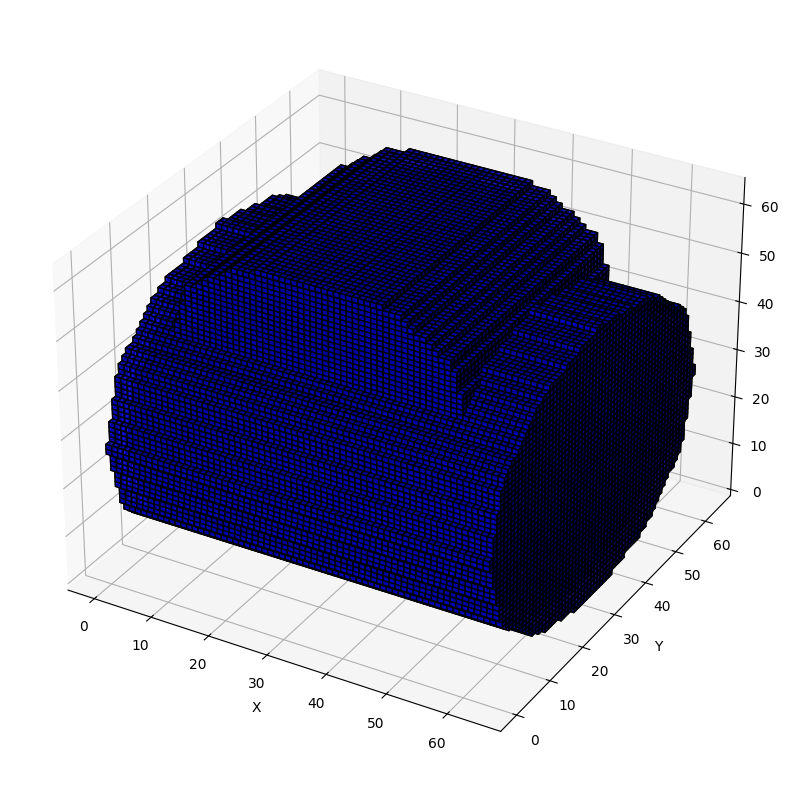

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_voxel_model(voxel_tensor):
    """
    Визуализирует 3D-воксельную модель.

    Args:
        voxel_tensor (numpy.ndarray or torch.Tensor): 3D-массив вокселей.
    """
    # Убедимся, что это numpy-массив
    if isinstance(voxel_tensor, torch.Tensor):
        voxel_tensor = voxel_tensor.cpu().numpy()
        print("Да")
    
    # Создаем 3D-график
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    print("График")
    # Воксели с True будут отрисованы
    ax.voxels(voxel_tensor, facecolors='blue', edgecolors='k', alpha=0.7)
    print("Воксели")
    # Настраиваем оси
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()
    
# Предположим, ten — это воксельная модель в виде 3D-тензора
plot_voxel_model(ten)

In [36]:
print(ten[ten < 1])
print(ten.shape)

tensor([0., 0., 0.,  ..., 0., 0., 0.])
torch.Size([64, 64, 64])


In [182]:
def pad_voxel(voxel, target_shape):
    """
    Паддинг вокселя до целевого размера.
    """
    diff = [max(0, t - s) for s, t in zip(voxel.shape, target_shape)]
    padding = [(0, d) for d in diff[::-1]]  # Обратный порядок для PyTorch
    voxel_padded = F.pad(voxel, pad=[p for sub in padding for p in sub])
    return voxel_padded

In [ ]:
class STLDataset(Dataset):
    def __init__(self, files1, files2, resolution=64):
        """
        :param files1: Список путей к исходным STL-файлам (истинные модели).
        :param files2: Список путей к искаженным STL-файлам (входные модели).
        :param resolution: Размер воксельной сетки (например, 64x64x64).
        """
        assert len(files1) == len(files2), "Количество файлов в files1 и files2 должно совпадать"
        self.files1 = files1
        self.files2 = files2
        self.resolution = resolution

    def __len__(self):
        return len(self.files1)

    def __getitem__(self, idx):
        voxel1 = stl_to_voxel(self.files1[idx], self.resolution)
        voxel2 = stl_to_voxel(self.files2[idx], self.resolution)
        # target_shape = (self.resolution, self.resolution, self.resolution)
        # voxel1 = pad_voxel(voxel1, target_shape)
        # voxel2 = pad_voxel(voxel2, target_shape)
        return voxel2, voxel1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.threshold = nn.Parameter(torch.tensor(0.5))

        self.encoder = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv3d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 4 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 256 * 4 * 4 * 4)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(256, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(32, 1, kernel_size=3, stride=2, padding=1),
            nn.Sigmoid()
        )
        
        # Обучаемый параметр порога
        self.threshold = nn.Parameter(torch.tensor(0.5))  # Начальный порог

    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = x.view(x.size(0), 256, 4, 4, 4)
        x = self.decoder(x)
        
        # Применяем порог для бинаризации (во время тренировки можно отключить)
        # binary_output = (x > self.threshold).float()
        binary_preds = torch.sigmoid(x - self.threshold)
        return binary_preds

In [211]:
class WeightedLoss(nn.Module):
    def __init__(self, alpha=2.0):
        super(WeightedLoss, self).__init__()
        self.alpha = alpha

    def forward(self, predictions, targets, threshold):
        # Используем градиентоподдерживаемую бинаризацию
        #probs = torch.sigmoid(predictions - threshold)
        probs = predictions
        binary_preds = (probs > 0.5).float()  # Для интерпретации (гибкая бинаризация)

        # Вычисляем FP и FN
        false_positive = probs * (1 - targets)  # FP через вероятности
        false_negative = (1 - probs) * targets  # FN через вероятности

        # Потери
        fp_loss = false_positive.sum() * self.alpha
        fn_loss = false_negative.sum()

        # Общая потеря
        total_loss = (fp_loss + fn_loss) / targets.numel()
        return total_loss

In [212]:
def train_autoencoder(stl_dir1, stl_dir2, epochs=15, batch_size=4, lr=0.0005, val_split=0.2, resolution=VOXEL_RESOLUTION):
    # Проверяем доступность CUDA
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Находим файлы с одинаковыми именами
    common_files = get_common_files(stl_dir1, stl_dir2)

    # Формируем пути к файлам
    all_files1 = [os.path.join(stl_dir1, f) for f in common_files]
    all_files2 = [os.path.join(stl_dir2, f) for f in common_files]

    # Делим данные на обучающие и валидационные наборы
    train_files1, val_files1, train_files2, val_files2 = train_test_split(
        all_files1, all_files2, test_size=val_split, random_state=42
    )

    # Создаем датасеты
    train_dataset = STLDataset(train_files1, train_files2, resolution=resolution)
    val_dataset = STLDataset(val_files1, val_files2, resolution=resolution)

    # Создаем DataLoader'ы
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Модель, оптимизатор и функция потерь
    model = AutoEncoder().to(device)  # Переносим модель на GPU
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
   # loss_fn = nn.MSELoss()
    loss_fn = WeightedLoss(10)

    # Обучение
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for noisy, target in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            # Переносим данные на GPU
            noisy, target = noisy.float().to(device), target.float().to(device)

            # Изменяем размер целевого тензора до разрешения модели
            target_resized = torch.nn.functional.interpolate(
                target, size=(resolution, resolution, resolution), mode='trilinear', align_corners=False
            )

            optimizer.zero_grad()
            output = model(noisy)

            # Изменяем размер выходного тензора, чтобы совпадал с целевым
            output_resized = torch.nn.functional.interpolate(
                output, size=(resolution, resolution, resolution), mode='trilinear', align_corners=False
            )

            # Вычисляем функцию потерь
            loss = loss_fn(output_resized, target_resized, model.threshold)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Валидация
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for noisy, target in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{epochs}"):
                # Переносим данные на GPU
                noisy, target = noisy.float().to(device), target.float().to(device)

                # Изменяем размер целевого тензора
                target_resized = torch.nn.functional.interpolate(
                    target, size=(resolution, resolution, resolution), mode='trilinear', align_corners=False
                )

                output = model(noisy)

                # Изменяем размер выходного тензора
                output_resized = torch.nn.functional.interpolate(
                    output, size=(resolution, resolution, resolution), mode='trilinear', align_corners=False
                )

                # Вычисляем функцию потерь
                loss = loss_fn(output_resized, target_resized, model.threshold)
                val_loss += loss.item()

        # Выводим результаты текущей эпохи
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}")

    return model

In [213]:
stl_dir1 = '../STL_Data'
stl_dir2 = 'ModelsSTL'
model = train_autoencoder(stl_dir1, stl_dir2)

Using device: cuda


Training Epoch 1/15:   1%|▏         | 1/71 [00:12<14:28, 12.41s/it]


KeyboardInterrupt: 

In [ ]:
# Указываем путь для сохранения весов модели
weights_save_path = "autoencoder_weights.pth"

# Сохраняем веса модели
torch.save(model.state_dict(), weights_save_path)
print(f"Weights saved at {weights_save_path}")
torch.save(model, "autoencoder_full_model.pth")

Да
График
Воксели


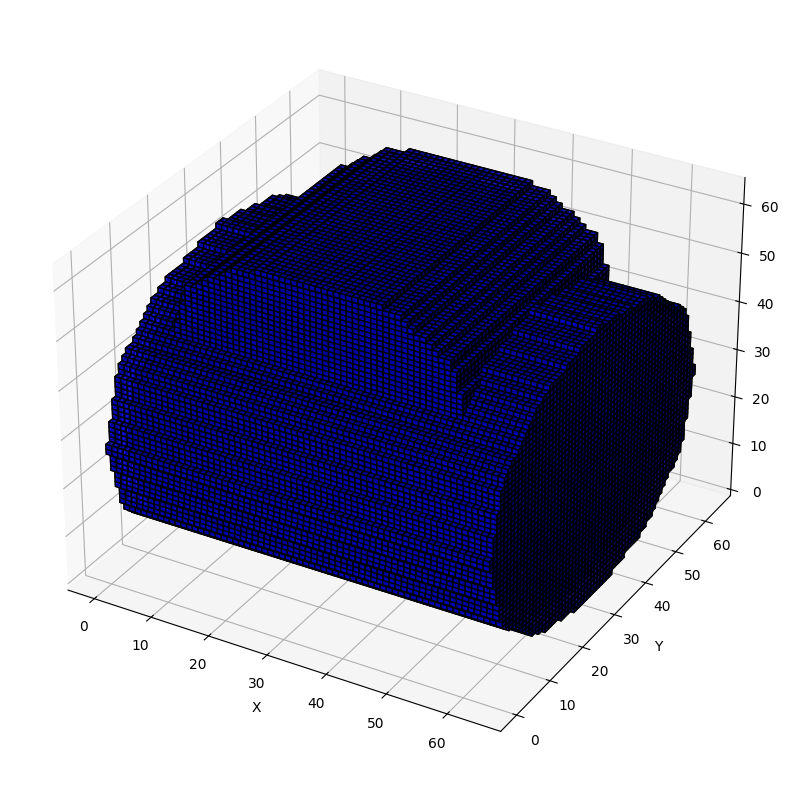

In [45]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_voxel_model(voxel_tensor):
    """
    Визуализирует 3D-воксельную модель.

    Args:
        voxel_tensor (numpy.ndarray or torch.Tensor): 3D-массив вокселей.
    """
    # Убедимся, что это numpy-массив
    if isinstance(voxel_tensor, torch.Tensor):
        voxel_tensor = voxel_tensor.cpu().numpy()
        print("Да")
    
    # Создаем 3D-график
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    print("График")
    # Воксели с True будут отрисованы
    ax.voxels(voxel_tensor, facecolors='blue', edgecolors='k', alpha=0.7)
    print("Воксели")
    # Настраиваем оси
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()
    
# Предположим, ten — это воксельная модель в виде 3D-тензора
plot_voxel_model(ten)

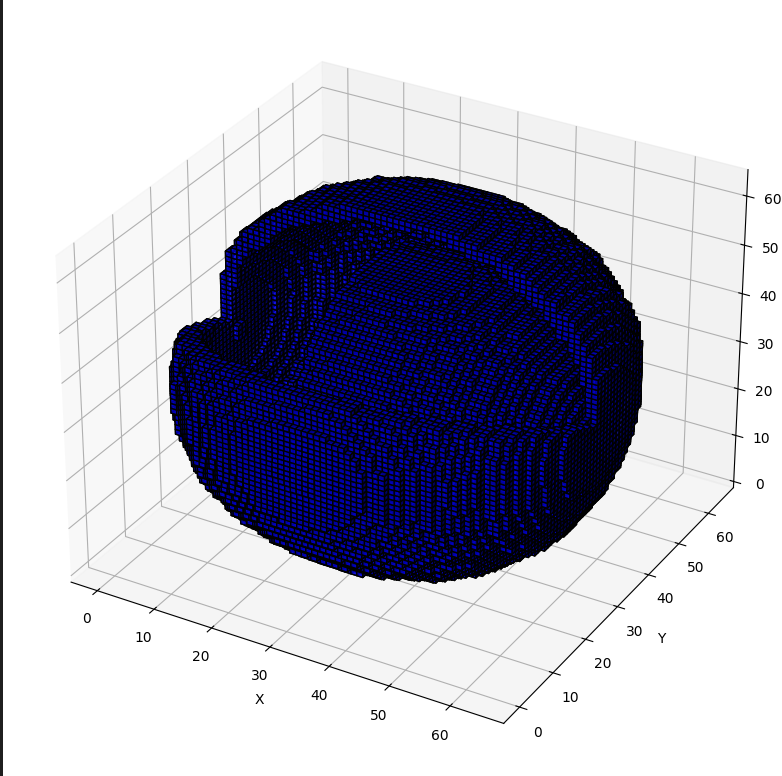

In [46]:
# Указываем путь для сохранения весов модели
weights_save_path = "autoencoder_weights.pth"

# Сохраняем веса модели
torch.save(model.state_dict(), weights_save_path)
print(f"Weights saved at {weights_save_path}")

Weights saved at autoencoder_weights.pth


In [47]:
model = torch.load("autoencoder_full_model.pth")
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): ReLU()
    (2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (3): ReLU()
    (4): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (5): ReLU()
    (6): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (7): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=16384, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): ReLU()
    (2): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (3): ReLU()
    (4): ConvTranspose3d(64, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (5): ReLU()
    (6): ConvTranspose3d(

In [56]:
class AutoEncoderExecutor:
    def __init__(self, model_path, device='cpu'):
        """
        Инициализация executor: загрузка модели и настройка устройства.
        
        :param model_path: Путь к сохраненной модели или весам.
        :param device: Устройство для выполнения ('cpu' или 'cuda').
        """
        self.device = torch.device(device)
        self.model = AutoEncoder()  # Инициализируем архитектуру модели
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))  # Загружаем веса
        self.model.to(self.device)  # Переносим на устройство
        self.model.eval()  # Переводим модель в режим оценки

    def preprocess(self, noisy_tensor, resolution=64):
        """
        Предобработка входных данных: изменение размера до нужного разрешения.
        
        :param noisy_tensor: Входной воксельный тензор (например, из STL-файла).
        :param resolution: Требуемое разрешение (по умолчанию 64x64x64).
        :return: Подготовленный тензор.
        """
        # Проверяем размерности и добавляем оси batch и channel, если нужно
        if noisy_tensor.dim() == 3:  # Если размерность 3D (D, H, W)
            noisy_tensor = noisy_tensor.unsqueeze(0).unsqueeze(0)  # Добавляем (N=1, C=1)
        elif noisy_tensor.dim() == 4:  # Если размерность уже 4D (N, D, H, W)
            noisy_tensor = noisy_tensor.unsqueeze(1)  # Добавляем C=1
        elif noisy_tensor.dim() != 5:
            raise ValueError("Input tensor must be 3D, 4D, or 5D")
        
        # Убеждаемся, что форма [N, C, D, H, W]
        preprocessed = F.interpolate(
            noisy_tensor, size=(resolution, resolution, resolution),
            mode='trilinear', align_corners=False
        )
        return preprocessed.to(self.device)

    def predict(self, noisy_tensor):
        """
        Выполняет предсказание на входных данных.
        
        :param noisy_tensor: Входной воксельный тензор.
        :return: Результат реконструкции воксельной модели.
        """
        # Предобработка
        preprocessed = self.preprocess(noisy_tensor)
        
        # Предсказание
        with torch.no_grad():
            reconstructed = self.model(preprocessed)
        
        # Убираем добавленные размерности
        return reconstructed.squeeze().cpu()

    def execute(self, input_path, resolution=64):
        """
        Полный процесс выполнения: от загрузки данных до сохранения результата.
        
        :param input_path: Путь к входному STL-файлу.
        :param output_path: Путь для сохранения реконструированного воксельного тензора.
        :param resolution: Требуемое разрешение реконструированной модели.
        """
        # Преобразуем STL в воксели
        noisy_tensor = stl_to_voxel(input_path, resolution=resolution)
        
        # Реконструкция
        reconstructed = self.predict(noisy_tensor)
        
        # Сохраняем результат
        # torch.save(reconstructed, output_path)
        # print(f"Reconstructed model saved at {output_path}")
        return reconstructed

In [97]:
ten = stl_to_voxel("C:/Users/Maksim/Desktop/Хакатонs/AIIngeneer/Задача1/Photo2CAD/ModelsSTL/00000039.stl")

In [98]:
ten.shape

torch.Size([1, 64, 64, 64])

In [ ]:
ten = stl_to_voxel("C:/Users/Maksim/Desktop/Хакатонs/AIIngeneer/Задача1/Photo2CAD/ModelsSTL/00000065.stl")

In [58]:
executor = AutoEncoderExecutor('autoencoder_weights.pth')

In [116]:
input_stl = "C:/Users/Maksim/Desktop/Хакатонs/AIIngeneer/Задача1/Photo2CAD/ModelsSTL/00000016.stl"

# Выполнение реконструкции
model_tensor = executor.execute(input_path=input_stl)

In [117]:
model_tensor

tensor([[[2.4032e-01, 2.1081e-01, 2.1700e-01,  ..., 1.8278e-01,
          2.1246e-01, 2.2781e-01],
         [2.1086e-01, 5.0150e-02, 2.1830e-01,  ..., 1.8146e-01,
          1.7251e-03, 2.2233e-01],
         [1.7624e-01, 1.8302e-01, 1.9561e-01,  ..., 1.7318e-01,
          2.1580e-01, 1.8356e-01],
         ...,
         [1.7230e-01, 1.8891e-01, 1.7052e-01,  ..., 1.2494e-01,
          1.6927e-01, 1.7435e-01],
         [2.0364e-01, 3.1325e-02, 2.6710e-01,  ..., 2.4269e-01,
          9.1843e-03, 2.1070e-01],
         [2.0692e-01, 2.0047e-01, 1.7704e-01,  ..., 1.6943e-01,
          1.8676e-01, 2.0314e-01]],

        [[1.9502e-01, 1.7493e-01, 2.2019e-01,  ..., 1.8351e-01,
          1.2379e-01, 1.8518e-01],
         [1.6052e-01, 7.6111e-03, 1.9821e-02,  ..., 8.0460e-02,
          6.5682e-02, 1.9429e-01],
         [1.4093e-01, 1.0491e-01, 3.2838e-02,  ..., 5.1922e-03,
          1.1982e-01, 1.4591e-01],
         ...,
         [1.2682e-01, 2.3267e-02, 1.2186e-01,  ..., 1.8145e-02,
          5.442

In [118]:
model_tensor[model_tensor > 0.1].mean()

tensor(0.2169)

In [119]:
model_tensor.shape[0]

49

In [120]:
model_tensor[model_tensor > 0.1].shape

torch.Size([30400])

In [121]:
model_tensor[model_tensor > 0.05].shape[0]/model_tensor[model_tensor > 0].shape[0]

0.4881384457156457

In [122]:
def binary_threshold(tensor, threshold=None):
    """
    Бинаризация воксельного тензора по порогу.
    
    :param tensor: Входной тензор (например, реконструированный).
    :param threshold: Порог бинаризации. Если None, используется среднее значение.
    :return: Бинаризованный тензор.
    """
    if threshold is None:
        # Используем среднее значение в качестве порога
        threshold = tensor.mean().item()
        print(f"Автоматически выбран порог: {threshold:.4f}")
    
    # Бинаризация
    binary_tensor = (tensor > threshold).float()  # True/False -> 1/0
    return binary_tensor

In [123]:
binary_tensor = binary_threshold(model_tensor)
print(f"Размеры бинаризованного тензора: {binary_tensor.shape}")

# Проверяем соотношение заполненных вокселей
filled_voxels = binary_tensor.sum().item()
total_voxels = binary_tensor.numel()
print(f"Заполненных вокселей: {filled_voxels} из {total_voxels} ({100 * filled_voxels / total_voxels:.2f}%)")

Автоматически выбран порог: 0.0803
Размеры бинаризованного тензора: torch.Size([49, 49, 49])
Заполненных вокселей: 39469.0 из 117649 (33.55%)


In [167]:
# Устанавливаем порог вручную
manual_threshold = 0.23  # Зависит от диапазона значений в tensor
binary_tensor_manual = binary_threshold(model_tensor, threshold=manual_threshold)

# Проверяем вручную бинаризованный результат
filled_voxels = binary_tensor_manual.sum().item()
print(f"Заполненных вокселей при пороге {manual_threshold}: {filled_voxels}")

Заполненных вокселей при пороге 0.23: 10539.0


График
Воксели


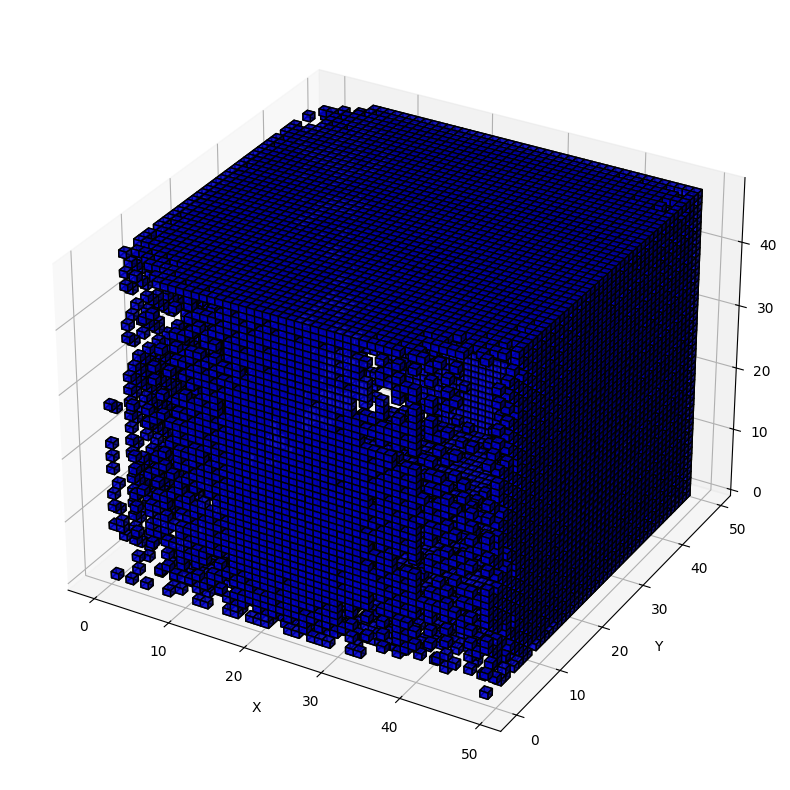

In [168]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_voxel_model(voxel_tensor):
    """
    Визуализирует 3D-воксельную модель.

    Args:
        voxel_tensor (numpy.ndarray or torch.Tensor): 3D-массив вокселей.
    """
    # Убедимся, что это numpy-массив
    if isinstance(voxel_tensor, torch.Tensor):
        voxel_tensor = voxel_tensor.cpu().numpy()
        print("Да")
    
    # Создаем 3D-график
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    print("График")
    # Воксели с True будут отрисованы
    ax.voxels(voxel_tensor, facecolors='blue', edgecolors='k', alpha=0.7)
    print("Воксели")
    # Настраиваем оси
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()
    
# Предположим, ten — это воксельная модель в виде 3D-тензора
plot_voxel_model(binary_tensor_manual.cpu().numpy())

In [169]:
target_ten = stl_to_voxel("C:/Users/Maksim/Desktop/Хакатонs/AIIngeneer/Задача1/STL_Data/00000016.stl")

In [170]:
target_ten = target_ten.squeeze()

Да
График
Воксели


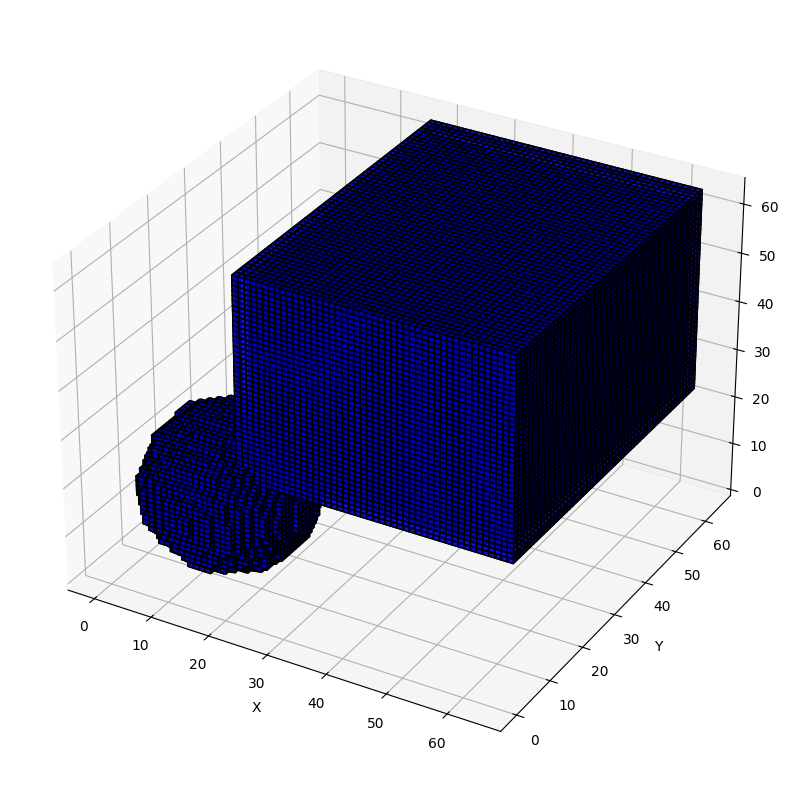

In [171]:
plot_voxel_model(target_ten)

In [4]:
import trimesh
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import numpy as np
import trimesh
from skimage import measure


import cv2
import math

#################################################################################### Алгоритм
def execute(front_image, side_image, top_image, scad_path, openscad_path, output_stl):
    class node:
        t = 0  # Translation has happened or not
        ro = 0  # Rotation has happened or not
        # Translation values
        tx = 0
        ty = 0
        tz = 0
        # Rotation values
        rx = 0
        ry = 0
        rz = 0

        def __init__(self, shape='set', operation='None',
                    l=0, b=0, h=0,
                    fn=12, fa=12, fs=2, r=0, r1=0,
                    center="true"):
            self.left = 'None'
            self.right = 'None'
            self.string = ''
            self.operation = operation
            self.shape = shape
            self.l = l
            self.b = b
            self.h = h
            self.fn = fn
            self.fa = fa
            self.fs = fs
            self.r = r  # Radius
            self.r1 = r1
            self.center = center

        def translate(self, x=0, y=0, z=0):
            self.tx = x
            self.ty = y
            self.tz = z
            self.t = 1

        def rotate(self, x=0, y=0, z=0):
            self.rx = x
            self.ry = y
            self.rz = z
            self.ro = 1

        def name(self):
            if(self.t == 1):
                self.string = 'translate([' + str(self.tx) + ',' + \
                    str(self.ty) + ',' + str(self.tz) + ']){\n\t'
            if(self.ro == 1):
                if(self.t == 1):
                    self.string = self.string + \
                        'rotate([' + str(self.rx) + ',' + str(self.ry) + \
                        ',' + str(self.rz) + ']){\n\t\t'
                else:
                    self.string = self.string + \
                        'rotate([' + str(self.rx) + ',' + str(self.ry) + \
                        ',' + str(self.rz) + ']){\n\t'
            if(self.shape == "cube"):
                self.string = self.string + 'cube([' + str(self.l) + ',' + str(
                    self.b) + ',' + str(self.h) + '], center = ' + self.center + ');\n'
            if(self.shape == "cylinder"):
                self.string = self.string + 'cylinder($fn = ' + str(self.fn) + ', h = ' + str(self.h) + ', r1 = ' + str(self.r) + \
                    ', r2 = ' + str(self.r1) + ', center = ' + self.center + ');\n'
            if(self.shape == "sphere"):
                self.string = self.string + 'sphere($fn = ' + str(self.fn) + ', $fa = ' + str(self.fa) + ', $fs = ' + str(self.fs) + \
                    'r = ' + str(self.r) + ');\n'
            if(self.ro == 1 and self.t == 1):
                self.string = self.string + "\t}\n"
            if(self.ro == 1 or self.t == 1):
                self.string = self.string + "}\n"

        def setr(self, r):
            self.r = r

        def setl(self, l):
            self.l = l

        def setb(self, b):
            self.b = b

        def seth(self, h):
            self.h = h

        def setr1(self, r):
            self.r1 = r

        def setoperation(self, operation):
            self.operation = operation



    import cv2
    import math

    # Round up


    def round_up(n, decimals=2):
        multiplier = 10 ** decimals
        n = math.ceil(n * multiplier) / multiplier
        return n

    # To rearrange the parts in the views, like for front store all the parts such that the center of the shape is arranged in descending order of x pixel value
    # otherwise do ascending order in side and top


    def re_arrange(objects, type):
        if(type == "front"):
            objects.sort(key=lambda x: x[0][1][0], reverse=True)
        else:
            objects.sort(key=lambda x: x[0][1][0])


    def draw_contour(img, out):
        # Converting into greyscale
        imgrey = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
        # COnverting into greyscale image to black and white image
        ret, thresh = cv2.threshold(imgrey, 127, 255, cv2.THRESH_BINARY_INV)
        # Finding contours
        contours, hierarchy = cv2.findContours(
            thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        # REarranging in descending order of area
        hierarchy, contours = zip(
            *sorted(zip(hierarchy[0], contours), key=lambda x: cv2.contourArea(x[1]), reverse=True))

        for i, c in enumerate(contours):

            if (hierarchy[i][3] != -1 or (hierarchy[i][3] == -1 and hierarchy[i][2] == -1)):
                M = cv2.moments(c)
                if(M["m00"] != 0):
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    area = cv2.contourArea(c)
                    rect = cv2.minAreaRect(c)

                    # Ignoring small areas
                    # if(area <= 4):
                    #     break

                    # calculate coordinates of the minimum area rectangle
                    box = cv2.boxPoints(rect)
                    # draw the countour number on the image
                    # cv2.putText(img, "#{}".format( i), (box[0][0], box[0][1]), cv2.FONT_HERSHEY_SIMPLEX,
                    #     1.0, (255, 0, 0), 1)
                    # draw contours
                    cv2.drawContours(img, [c], 0, (0, 0, 255), 1)
        cv2.imwrite(out, img)


    def add_part(objects, part, pos, type, ratio):

        # Translate based on the centers of the given shape with largest shape
        if(type == "front"):
            part[0].translate(round_up((part[1][0]-pos[0]) * ratio),
                            0, round_up((pos[1]-part[1][1]) * ratio))
        if(type == "side"):
            part[0].translate(0, round_up((part[1][0]-pos[0]) * ratio),
                            round_up((pos[1]-part[1][1]) * ratio))
        if(type == "top"):
            part[0].translate(round_up((part[1][1]-pos[1]) * ratio),
                            round_up((part[1][0]-pos[0]) * ratio), 0)

        # Search for the parent shape and place it inside that parent list
        for i, object in enumerate(objects):
            if(cv2.pointPolygonTest(object[0][2], part[1], False) >= 0):
                part[0].operation = "difference"
                #Adding in position
                object.append(part)
                return

        # If shape not found his parent, make a new list making it has parent
        objects.append([part])
        return


    def combining(front_parts, side_parts, top_parts, roundOffApprox):
        # All the views are thought to be seen in y direction
        # For cube the "l" is length that is length of the rectangle/sqaure, "h" is height that is nothing but breadth of rectangle/sqaure,
        # "b" is the breath(thickness in y direction) of the cube
        # Cylinder will be upright position along z-axis(i.e when no ration is applied)

        # Looping through the Different parent child lists
        for i, front in enumerate(front_parts):
            first = 0
            # looping through all the parts of a parent and its child
            for j, part_f in enumerate(front):
                # part length is usually 5 - includes shape object,center,contour,height and width, if its six the shape is already considered and finalised
                if(len(part_f) >= 6):
                    continue
                # Give the width of the parent to all its child when the parent is width found from side view
                if(first == 1):
                    # If the child shape is cube
                    if(part_f[0].shape == "cube"):
                        # Parent is also cube

                        if(front[0][0].shape == "cube"):
                            part_f[0].b = front[0][0].b
                        else:
                            part_f[0].b = front[0][0].h
                        # when the parent is rotated in z axis
                        if(front[0][0].rz != 0):
                            part_f[0].b = front[0][3]
                    # If the child is cylinder
                    if(part_f[0].shape == "cylinder"):
                        #Parent is cube
                        if(front[0][0].shape == "cube"):
                            part_f[0].h = front[0][0].b
                        else:
                            part_f[0].h = front[0][0].h
                        # when the parent is rotated in z axis
                        if(front[0][0].rz != 0):
                            part_f[0].h = front[0][3]
                # For checking whether the front shape is visible in side
                found = 0
                # Search side view
                for k, side in enumerate(side_parts):
                    # For adding rest of the shapes in side view list, once a shape is found
                    add_rest = 0
                    for l, part_s in enumerate(side):
                        # ADD inner parts of side view only visible from side view and making sure the same shape is not added again once the shape is available in side view
                        if(add_rest == 1 and part_s[3] != -1):
                            # Increasing the size of parts list
                            part_s.append("used")
                            part_s[3] = -1
                            # Giving the x translation
                            part_s[0].tx = part_f[0].tx
                            # If the shape is cylinder give height to it
                            if(part_s[0].shape == "cylinder"):
                                part_s[0].h = part_f[4]
                            # If its a cube give breadth
                            elif(part_s[0].shape == "cube"):
                                part_s[0].b = part_f[4]
                            front.append(part_s)

                            continue
                        # check whether the height in front view is same in side view
                        if(abs(part_f[3]-part_s[3]) < roundOffApprox and found == 0):
                            # If the shape is found in side view
                            found = 1
                            # If its a parent in front view
                            if(j == 0):
                                first = 1
                            # If the side shape is not parent then its protruding, so make the operation as union
                            if(l != 0):
                                part_s[0].operation = "union"
                            # If Front view is cube
                            if(part_f[0].shape == "cube"):
                                # If side view is also cube
                                if(part_s[0].shape == "cube"):
                                    # Check whether it is cylinder in top view or if there is any rotation in z-axis if the top view is also found to be cube

                                    for top in top_parts:
                                        for m, part_t in enumerate(top):
                                            # Checking whether the shape is available in top view by comparing the height in top view
                                            # with the width in front view, as all the shapes are considered to be viewed in the direction of y-axis we need to compare
                                            # the height in top view with width in front view
                                            if(abs(part_t[3] - part_f[4]) < roundOffApprox and len(part_t) == 5):

                                                # If the shape in top view is child it must be protruding from it's parent to be visible in front view, so
                                                # we change the operation of the shape of the top view to union operation
                                                if(m != 0):
                                                    part_t[0].operation = "union"
                                                # If it is a parent make the operation None
                                                if(j == 0):
                                                    part_t[0].operation = "None"
                                                # If its a circle from top view replace the front view in "front_part" list with top view shape, while giving it a height
                                                #  and z-translate
                                                if(part_t[0].shape == "cylinder"):
                                                    # Providing height and z-tranzlate for the shape in top view
                                                    part_t[0].h = part_f[0].h
                                                    part_t[0].tz = part_f[0].tz
                                                    # Get to know the position of which parent we are adding in "front_part" so that the remaining shapes
                                                    # in the top view after this shape can be added later into the "front_part" list
                                                    part_t[1] = i
                                                    # Marking that the shape in the top view is used
                                                    part_t[2] = -1
                                                    part_t.append("used")
                                                    # Replace the shape in the front view by the shape obtained from top view
                                                    part_f[0] = part_t[0]
                                                    # Mark that the side view is used
                                                    part_s[3] = -1
                                                    # Giving signal to add rest of the child in side view after the current shape
                                                    add_rest = 1
                                                    break
                                                if(part_t[0].shape == "cube" and part_s[0].ry == 0 and part_f[0].ry == 0 and part_t[0].rz != 0 and abs(part_t[0].rz) != 90):
                                                    # For the top view, cube will be rotated along x-axis so we need to provide them breadth rather
                                                    #  than height
                                                    part_t[0].b = part_f[0].h
                                                    # Provide the z-translation from top view
                                                    part_t[0].tz = part_f[0].tz
                                                    # Get to know the position of which parent we are adding in "front_part" so that the remaining shapes
                                                    # in the top view after this shape can be added later into the "front_part" list
                                                    part_t[1] = i
                                                    # Marking that the shape in the top view is used
                                                    part_t[2] = -1
                                                    part_t.append("used")
                                                    # Replace the shape in the front view by the shape obtained from top view
                                                    part_f[0] = part_t[0]
                                                    # giving the thickness of the shape, helpful when the parent is rotated along z axis
                                                    part_f[3] = part_t[3]
                                                    # Mark that the side view is used
                                                    part_s[3] = -1
                                                    # Giving signal to add rest of the child in side view after the current shape
                                                    add_rest = 1
                                                    break
                                        else:
                                            # Using for else construct, which helps here to continue to traverse through the list until the shape is found in top view
                                            # or it exists from the top_part loop
                                            continue
                                        # Reaches here if counterpart for the front shape is in top view
                                        break
                                # If the shape was found in top view and we if we replaced with top view, then skip rest of the work below it
                                if(part_s[3] == -1):
                                    continue

                                # If the side view is cylinder
                                if(part_s[0].shape == "cylinder"):
                                    # Get height of the cylinder
                                    part_s[0].h = part_f[0].l
                                    # Get x-translation
                                    part_s[0].tx = part_f[0].tx
                                    # If the cube is front view cube is rotated along y axis
                                    part_s[0].ry = part_f[0].ry
                                    # Replace front view by side

                                    if(j == 0):  # If it is a parent make the operation None
                                        part_s[0].operation = "None"

                                    part_f[0] = part_s[0]
                                    part_s[3] = -1
                                    add_rest = 1
                                    continue

                                # If the side view is cube
                                if(part_s[0].shape == "cube"):
                                    # If the cube is rotated in front view i.e along y axis, then just provide the thickness and y translation
                                    if(part_f[0].ry != 0 or part_s[0].ry == 0):
                                        part_f[0].b = part_s[0].l
                                        part_f[0].ty = part_s[0].ty
                                        part_s[3] = -1
                                        add_rest = 1
                                        continue
                                    else:
                                        # Replacing front view by side view
                                        # thickness of the view
                                        part_s[0].b = part_f[0].l
                                        # x translation
                                        part_s[0].tx = part_f[0].tx
                                        # Replace front view by side view
                                        part_f[0] = part_s[0]
                                        part_s[3] = -1
                                        add_rest = 1
                                        continue

                            # If the shape in Front View is cylinder
                            if(part_f[0].shape == "cylinder"):
                                # If the side view is cube, which is obvious but still checking
                                if(part_s[0].shape == "cube"):
                                    # The thickness/height for the cylinder is given by the length of the cube in side view(as side view shapes are rotated
                                    # in 90 about z-axis) and also give the y-translation
                                    part_f[0].h = part_s[0].l
                                    part_f[0].ty = part_s[0].ty
                                    # If the cube is rotated along x axis, by x axis rotation in side view is given by y axis as we are rotating the side view
                                    # by 90 along z axis
                                    part_f[0].rx = part_s[0].ry

                            # Side shape is used
                            part_s[3] = -1
                            # Add the rest of the shapes in side view for this parent/ this child's parent
                            add_rest = 1
                            continue
                    # If the shape in front view is already found, dont check any other shapes in the next parent child list
                    if(found == 1):
                        break

                # If the corresponding shape of the front view is not found in side view check in top view to get the thickness of the shape
                if(found == 0):
                    # Search top view, here we are assuming
                    for top in top_parts:
                        for m, part_t in enumerate(top):

                            # Checking whether the height of top view is same as width in front view and the top view shape should not be used before
                            if((abs(part_t[3]-part_f[4]) < roundOffApprox) and len(part_t) == 5):
                                # Experimental :- Check if the front shape is child, and x translation is too far - neglect same height in top and width in front which are of different shape
                                if(abs(part_f[0].tx - part_t[0].tx) > 0.5):
                                    continue
                                # Checking whether the front view is a parent or not
                                if(j == 0):
                                    first = 1
                                # If the shape in top view is child it must be protruding from it's parent to be visible in front view, so
                                # we change the operation of the shape of the top view to union operation
                                if(m != 0):
                                    part_t[0].operation = "union"
                                # If it's a cylinder provide height and y-translation
                                if(part_f[0].shape == "cylinder"):
                                    # This checking is not required as it is obvious, but still doing anyway
                                    if(part_t[0].shape == "cube"):
                                        part_f[0].h = part_t[0].h
                                        part_f[0].ty = part_t[0].ty
                                        # If the cube is rotated in z axis
                                        part_f[0].rz = part_t[0].rz
                                        # For adding the rest of the child later give the top shape with height, z-translation and the position of the
                                        # "front_parts" we are comparing now
                                        part_t[0].b = part_f[3]
                                        part_t[0].tz = part_f[0].tz
                                        # Get to know the position of which parent we are adding in "front_part" so that the remaining shapes
                                        # in the top view after this shape can be added later into the "front_part" list
                                        part_t[1] = i
                                        # Marking that the shape in the top view is used
                                        part_t[2] = -1
                                        part_t.append("used")
                                        break

                                if(part_f[0].shape == "cube"):

                                    part_t[0].tz = part_f[0].tz
                                    if(part_t[0].shape == "cube"):
                                        part_t[0].b = part_f[0].h
                                        # Check whether the cube is rotated along z axis( in top view)
                                        if(part_t[0].rz != 0):
                                            part_f[0] = part_t[0]
                                        else:
                                            # Getting thickness for the front view, which is the length of the top view
                                            part_f[0].b = part_t[0].l
                                            part_f[0].ty = part_t[0].ty

                                    elif(part_t[0].shape == " cylinder"):
                                        # If cube is rotated along y axis
                                        part_t[0].ry = part_f[0].ry
                                        part_t[0].h = part_f[0].h
                                        part_f[0] = part_t[0]

                                    part_t[1] = j
                                    # Marking that the shape in the top view is used
                                    part_t[2] = -1
                                    part_t.append("used")
                                    break
                        else:
                            # Continue until you find the matching of front and top view
                            continue
                        break

        # Add the shape that is only visible in side view and top view(parent part and its child)
        for side in side_parts:
            # If the parent is not used, get the thickness from top view, we are not checking front view because all the shapes visible in front view
            # are already considered
            if(side[0][3] != -1):
                addCompleteList = []
                for part_s in side:
                    # Looping through top view
                    if(part_s[3] == -1):
                        break

                    for k, top in enumerate(top_parts):
                        for l, part_t in enumerate(top):
                            # Check whether their width are same in both side and top view and top view should not be used already
                            if((abs(part_s[4]-part_t[4]) < roundOffApprox) and len(part_t) == 5):

                                if(part_s[0].shape == "cube"):
                                    # Giving z-translation
                                    part_t[0].tz = part_s[0].tz
                                    if(part_t[0].shape == "cube"):
                                        # Giving thickness to top view shape
                                        part_t[0].b = part_s[0].h
                                        # Check whether the cube is rotated along z axis( in top view)
                                        if(part_t[0].rz != 0):
                                            part_s[0] = part_t[0]
                                        else:
                                            # Getting thickness for the front view
                                            part_s[0].b = part_t[0].h
                                            # Give x-translation
                                            part_s[0].tx = part_t[0].tx

                                    elif(part_t[0].shape == " cylinder"):
                                        # Rotated along x axis, but as we have rotated the side view along z axis to 90, we use ry of side view
                                        part_t[0].rx = part_s[0].ry
                                        part_t[0].h = part_s[0].h
                                        part_s[0] = part_t[0]

                                    # Getting the location of the parent-child side view we are going to add to "front_parts"
                                    part_t[1] = len(front_parts)
                                    # Marking that the shape in the top view is used
                                    part_t[2] = -1
                                    part_t.append("used")
                                # If its a cylinder get its height
                                if(part_s[0].shape == "cylinder"):
                                    # This checking is not required as it is obvious, but still doing anyway
                                    if(part_t[0].shape == "cube"):
                                        # Get height
                                        part_s[0].h = part_t[0].h
                                        # Give x-translation
                                        part_s[0].tx = part_t[0].tx
                                        # Rotation in z axis
                                        part_s[0].rz = part_t[0].rz
                                        # For adding the rest of the child later give the top shape with height, z-translation and the position of the
                                        # "front_parts" we are comparing now
                                        part_t[0].b = part_s[3]
                                        part_t[0].tz = part_s[0].tz
                                        # Get to know the position of which parent we are adding in "front_part" so that the remaining shapes
                                        # in the top view after this shape can be added later into the "front_part" list
                                        part_t[1] = len(front_parts)
                                        # Marking that the shape in the top view is used
                                        part_t[2] = -1
                                        part_t.append("used")
                    addCompleteList.append(part_s)
                # Append whole parent-child list into "front_parts"
                front_parts.append(addCompleteList)

        # Add shapes only visible in top
        for top in top_parts:
            # Need to give the top view heights
            height = -1
            # For z-translation
            tz = -1
            # Position of the parent-child list where we need to add, which is stores in part list earlier
            position = -1
            # Loop through parent-child list to first find the position of the shape which is used while comparing with front view
            for part_t in top:
                # Check whether the height of the used shape is given and also check whether the shape in top view is already used
                if(height != -1 and len(part_t) == 5):
                    # If its a cylinder provide height and z-translation
                    if(part_t[0].shape == "cylinder"):
                        part_t[0].h = height
                        part_t[0].tz = tz
                    # If its a cube provide breadth(as the cube is rotated along x axis in top view) and z-translation
                    elif (part_t[0].shape == "cube"):
                        part_t[0].b = height
                        part_t[0].tz = tz
                    # Appending the shape in front_parts in the position obtained from previous top shape
                    try:
                        front_parts[position].append(part_t)
                    except:
                        print("Error occurred")
                # Check if the given top view is used
                try:
                    class Spam(int):
                        pass
                    if(isinstance(Spam(part_t[2]), int)):
                        # Store its z-translation
                        tz = part_t[0].tz
                        # Get the position in front_parts list to add the rest of the child shape
                        position = part_t[1]
                        # Getting the height of the top shape already used, for cube its given by breadth, for cylinder, it is it's height
                        if(part_t[0].shape == "cylinder"):
                            height = part_t[0].h
                        elif (part_t[0].shape == "cube"):
                            height = part_t[0].b
                except TypeError:
                    pass

        return front_parts


    def detect(c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        # Finding the number of line segment required to make the polygon
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        # Cylinder type in openscad for making regular prism
        cylinder_type = 0

        # if the shape is a triangle, it will have 3 vertices
        if len(approx) == 3:
            shape = "triangle"
            cylinder_type = 3
        # if the shape has 4 vertices, it is either a square or a rectangle
        elif len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)
            rect = cv2.minAreaRect(c)
            ar = rect[1][0] / float(rect[1][1])
            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square" if ar >= 0.999 and ar <= 1.001 else "rectangle"

        # if the shape is a pentagon, it will have 5 vertices
        elif len(approx) == 5:
            shape = "pentagon"
            cylinder_type = 5
        # if the shape is a hexagon, it will have 6 vertices
        elif len(approx) == 6:
            shape = "hexagon"
            cylinder_type = 6
        # otherwise, we assume the shape is a circle
        else:
            shape = "circle"
            cylinder_type = 1

        # return the name of the shape
        return shape, cylinder_type


    def valid_contours(img, type, ratio):
        # List to build parent and child shapes
        objects = []
        # Converting into greyscale
        imgrey = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
        # COnverting into greyscale image to black and white image
        ret, thresh = cv2.threshold(imgrey, 127, 255, cv2.THRESH_BINARY_INV)
        # Finding contours
        contours, hierarchy = cv2.findContours(
            thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        # Rearranging such that the contours are arranged in descending order
        hierarchy, contours = zip(
            *sorted(zip(hierarchy[0], contours), key=lambda x: cv2.contourArea(x[1]), reverse=True))

        # Looping through all contours
        for i, c in enumerate(contours):
            # Choosing inner side of the two same shape created by thickness of the line
            if (hierarchy[i][3] != -1 or (hierarchy[i][3] == -1 and hierarchy[i][2] == -1)):
                M = cv2.moments(c)
                if(M["m00"] != 0):
                    # Getting the center of the contour
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    # Getting Contour area
                    area = cv2.contourArea(c)
                    # Rescaling based on input from user
                    area = area * ratio
                    # getting minimum area rectangle that is enclosing the contour
                    rect = cv2.minAreaRect(c)
                    # Ignoring small areas
                    if(area <= 4*ratio):
                        break
                    # calculate coordinates of the minimum area rectangle
                    box = cv2.boxPoints(rect)
                    # Rescaling based on input from user
                    rectLength = round_up(rect[1][0] * ratio)
                    rectBreadth = round_up(rect[1][1] * ratio)

                    # it's a horizontal rectangle which encloses the contour
                    x, y, w, h = cv2.boundingRect(c)
                    w = round_up(w * ratio)
                    h = round_up(h * ratio)
                    # Making largest contour's center has reference for translation of other shape
                    if(len(objects) == 0):
                        pos = [cX, cY]

                    # draw the contour number on the image
                    # cv2.putText(img, "#{}".format(i), (box[0][0], box[0][1]), cv2.FONT_HERSHEY_SIMPLEX,
                    #     1.0, (255, 0, 0), 1)
                    # draw contours
                    cv2.drawContours(img, [c], 0, (0, 0, 255), 1)
                    # Detecting the shape of the contour
                    shape, cylinder_type = detect(c)

                    # To store the shape and its details
                    part = []

                    if(shape == "square"):
                        # Adding shape
                        part.append(node(shape="cube", l=rectLength,
                                        b=rectLength, h=rectLength))
                        # Giving rotatation
                        if(type == "front"):
                            part[0].rotate(0, rect[2], 0)
                        elif(type == "side"):
                            part[0].rotate(0, rect[2], 90)
                        elif(rect[2] == 0):
                            part[0].rotate(90, 0, 90)
                        else:
                            part[0].rotate(90, 0, rect[2])

                        # Adding center of the contour
                        part.append(tuple([cX, cY]))
                        # Adding contour
                        part.append(c)
                        # Adding height of the horizontal rectangle enclosing the contour
                        part.append(h)
                        # Adding width of the horizontal rectangle enclosing the contour
                        part.append(w)
                        # Adding to the list of shape in parent child manner
                        add_part(objects, part, pos, type, ratio)
                    elif(shape == "rectangle"):
                        if(type == "front"):
                            if(rect[2] == -90):
                                part.append(
                                    node(shape="cube", l=rectBreadth, b=rectBreadth, h=rectLength))
                                part[0].rotate(0, 0, 0)
                            else:
                                part.append(
                                    node(shape="cube", l=rectLength, b=rectLength, h=rectBreadth))
                                part[0].rotate(0, rect[2], 0)
                        elif(type == "side"):
                            if(rect[2] == -90):
                                part.append(
                                    node(shape="cube", l=rectBreadth, b=rectBreadth, h=rectLength))
                                part[0].rotate(0, 0, 90)
                            else:
                                part.append(
                                    node(shape="cube", l=rectLength, b=rectLength, h=rectBreadth))
                                part[0].rotate(0, rect[2], 90)
                        # If there is no rotation in top view rotate 90 along in both x and z axis
                        elif(rect[2] == -90):
                            part.append(node(shape="cube", l=rectBreadth,
                                            b=rectBreadth, h=rectLength))
                            part[0].rotate(90, 0, 90)
                        elif(rect[2] == 0):
                            part.append(node(shape="cube", l=rectLength,
                                            b=rectLength, h=rectBreadth))
                            part[0].rotate(90, 0, 90)
                        else:
                            # If there is some rotation, rotate in z axis
                            part.append(node(shape="cube", l=rectLength,
                                            b=rectLength, h=rectBreadth))
                            part[0].rotate(90, 0, rect[2])

                        part.append(tuple([cX, cY]))
                        part.append(c)
                        part.append(h)
                        part.append(w)
                        add_part(objects, part, pos, type, ratio)
                    # Cylinder type in openscad
                    elif(cylinder_type > 0):
                        # Cylinder
                        if(shape == "circle"):
                            _, radius = cv2.minEnclosingCircle(c)
                            radius = round_up(radius * ratio)
                            part.append(
                                node(shape="cylinder", r=radius, r1=radius, h=rectLength))
                            if(type == "front"):
                                part[0].rotate(90, 0, 0)
                            elif(type == "side"):
                                part[0].rotate(0, 90, 0)
                            part.append(tuple([cX, cY]))
                            part.append(c)
                            part.append(h)
                            part.append(w)
                            add_part(objects, part, pos, type, ratio)
                        else:
                            # Regular prism
                            _, radius = cv2.minEnclosingCircle(c)
                            radius = round_up(radius * ratio)
                            part.append(node(shape="cylinder", r=radius,
                                            r1=radius, h=rectLength, fn=cylinder_type))
                            if(type == "front"):
                                part[0].rotate(90, -90 - rect[2], 0)
                            elif(type == "side"):
                                part[0].rotate(0, 90, 0)
                            else:
                                part[0].rotate(0, 0, rect[2])
                            part.append(tuple([cX, cY]))
                            part.append(c)
                            part.append(h)
                            part.append(w)
                            add_part(objects, part, pos, type, ratio)
                    else:
                        print("shape not detected")
        # cv2.imwrite("result1"+type+".png",img)
        return objects


    def writetofile(filename, string):
        file = open(filename, "a")
        file.write(string)
        file.close()


    def createtree(nodes, filename):
        if(len(nodes) == 0):
            print("No shapes detected")
            return

        subtree = []
        string = ''
        # Initialize empty node
        present = node()
        # Add the first node in left child
        present.left = nodes[0]
        # Generates function/string for the shape as in openscad
        nodes[0].name()
        # Add the generated string to the present node
        present.string = nodes[0].string
        # If there is only one node, write it to the file
        if(len(nodes) == 1):
            writetofile(filename, present.string)
        # If the number of nodes is more than one enter the loop
        for i, object in enumerate(nodes[1:]):
            # Generate function/statement for the shape as in openscad
            object.name()
            # If Node is child of shapes
            if(object.operation != 'None'):
                # If the right child in tree is free
                if(present.right == 'None'):
                    # Assign the right parent
                    present.right = object
                    # Update the present string
                    present.string = object.operation + \
                        "() {\n\t" + present.string + \
                        '\n\t' + object.string + '}\n'
                    # Store it for appending into the file
                    string = present.string
                else:
                    # If right is not free, create a new node and make the present node as left child to the new node
                    temp = present
                    present = node()
                    present.left = temp
                    present.string = temp.string
                    # Then make the object as right child of the new node
                    present.right = object
                    # Update the string
                    present.string = object.operation + \
                        "() {\n\t" + present.left.string + \
                        '\n\t' + object.string + '}\n'
                    # Store it for appending
                    string = present.string
            else:
                # Satisfies this condition only when there is two consecutive parent shape with no child
                if(present.right == 'None'):
                    # Append the present string to the file
                    writetofile(filename, present.string)

                # So as parent-child list is completly traversed, it is added to subtree and the subtree string is appended to the file
                subtree.append(present)
                writetofile(filename, string)
                # Create a new subtree
                string = ''
                present = node()
                present.left = object
                present.string = object.string
                # If the last node is the parent shape node
                if(i == len(nodes)-2):
                    writetofile(filename, present.string)
        # If the last node is a child shape node
        if(string != ''):
            writetofile(filename, string)
        # Add the last subtree
        subtree.append(present)
        print("Subtree:", len(subtree))


    import copy
    import json
    import os
    import shutil
    import cv2
    import numpy as np
    from matplotlib import pyplot as plt
    from IPython.display import Image


    def Dimensioning(view,image):

        #Creating temp directory if not present
        #os.makedirs('static/temp', exist_ok=True)
        #Getting user input from app
        img = cv2.imread(image,cv2.IMREAD_UNCHANGED)
        #Initialization
        ratio = 0
        shape = "unidentified"
        #Getting the size of image
        try:
            w,h,_=img.shape
            drawSize = int(h/300)
            # if(drawSize == 0):
            #     drawSize = 1
            #Convert image to grayscale
            imgrey = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
            #Convert image to black and white
            ret, thresh = cv2.threshold(imgrey,127,255,cv2.THRESH_BINARY_INV)
            #Find contours
            contours, hierarchy = cv2.findContours(thresh,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
            #Arrange the contours in descending order of area
            hierarchy,contours = zip(*sorted(zip(hierarchy[0],contours),key = lambda x: cv2.contourArea(x[1]),reverse=True))

            for i,c in enumerate(contours):
                #Get the outer most closed contour
                if(hierarchy[i][3] != -1  or (hierarchy[i][3] == -1 and hierarchy[i][2] == -1) ):
                    M = cv2.moments(c)
                    if(M["m00"] !=0):
                        cX = int(M["m10"] / M["m00"])
                        cY = int(M["m01"] / M["m00"])
                        #Getting the minimum area rectangle enclosing the contour
                        rect = cv2.minAreaRect(c)
                        box = cv2.boxPoints(rect)
                        box = np.int0(box)
                        #Getting horizontal rectangle enclosing the contour
                        x,y,w,h = cv2.boundingRect(c)

                        # cv2.putText(img, "#{}".format(i), (box[0][0], box[0][1]), cv2.FONT_HERSHEY_SIMPLEX,
                        #     textSize, (255, 0, 0), drawSize,cv2.LINE_AA)

                        #detect Shape
                        shape, cylinder_type = detect(c)              
                        if(shape == "unidentified"):
                            continue

                        if(shape=="triangle" or shape=="pentagon" or shape=="hexagon"):
                            img = cv2.drawContours(img, [box], 0, (0,0, 255), drawSize)
                        # w is the width of the rectagle enclosing the circle, i.e diameter of the circle
                        if(shape=="circle"):
                            # draw contours
                            img = cv2.rectangle(img,(x,y),(x+w,y+h),(0, 0, 255),drawSize)
                            cv2.line(img, (x,y), (x+w,y), (0,255, 0), 2)
                            ratio = 1/w
                        else:
                            # draw contours
                            # img = cv2.drawContours(img, [box], 0, (0,0, 255), drawSize)
                            cv2.line(img, tuple(box[0]), tuple(box[1]), (0,255, 0), 2)
                            #Length per pixel
                            ratio = 1.0/rect[1][1]
                        break

            
            ratio = str(ratio)
            data={'ratio': ratio}

            return data
        except:
            print(view + "image not found")

    import time

    def Convert(front_image, side_image, top_image, fratio, sratio, tratio, path_file):
        # store starting time 
        start = time.time() 

        img_front = cv2.imread(front_image,cv2.IMREAD_UNCHANGED)
        img_side = cv2.imread(side_image,cv2.IMREAD_UNCHANGED)
        img_top = cv2.imread(top_image,cv2.IMREAD_UNCHANGED)

        fratio = float(fratio)
        sratio = float(sratio)
        tratio = float(tratio)

        primitive = []

        object_front = valid_contours(img_front,"front",fratio)
        re_arrange(object_front,"front")
        
        object_side = valid_contours(img_side,"side",sratio)
        re_arrange(object_side,"side")

        object_top = valid_contours(img_top,"top",tratio)
        re_arrange(object_top,"top")

        minApprox = 0.05
        primitive = combining(object_front,object_side,object_top,minApprox)
        final = []
        for set in primitive:
            for shape in set:
                final.append(shape[0])
        

        createtree(final,path_file)

        end = time.time() 
        print("Total time taken to convert:",end-start)
        return path_file


    def executor(front_image, side_image, top_image, scad_path):
        d1 = Dimensioning("front",front_image)
        d2 = Dimensioning("side",side_image)
        d3 = Dimensioning("top",top_image)
        fratio = float(d1["ratio"]) * 2 
        sratio = float(d2["ratio"]) * 3 
        tratio = float(d3["ratio"]) * 1.73 
        Convert(front_image, side_image, top_image,fratio, sratio, tratio, scad_path)

    import os
    import subprocess
    def scad_to_stl(input_scad, output_stl):

        #openscad_path = "openscadExec\openscad.exe"
        command = [openscad_path, "-o", output_stl, input_scad]

        try:
            subprocess.run(command, check=True)
            print(f"Файл успешно конвертирован: {output_stl}")
        except FileNotFoundError:
            print("OpenSCAD не найден. Укажите правильный путь.")
        except subprocess.CalledProcessError:
            print("Ошибка при конвертации SCAD в STL.")

    executor(front_image, side_image, top_image, scad_path)
    scad_to_stl(scad_path, output_stl)

#################################################################################### Модель
    import torch
    import torch.nn as nn
    import torch.nn.functional as F

    class AutoEncoder(nn.Module):
        def __init__(self):
            super(AutoEncoder, self).__init__()
            self.threshold = nn.Parameter(torch.tensor(0.5))
            
            self.encoder = nn.Sequential(
                nn.Conv3d(3, 32, kernel_size=3, stride=2, padding=1),  
                nn.ReLU(),
                nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1),  
                nn.ReLU(),
                nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1), 
                nn.ReLU(),
            )

            self.fc1 = nn.Linear(128 * 1 * 16 * 16, 1024)
            self.fc2 = nn.Linear(1024, 128 * 8 * 8 * 8)  

            self.decoder = nn.Sequential(
                nn.ConvTranspose3d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  
                nn.ReLU(),
                nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   
                nn.ReLU(),
                nn.ConvTranspose3d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   
            )

        def forward(self, x):
            x = self.encoder(x)
            x = x.view(x.size(0), -1) 
            x = self.fc1(x)
            x = self.fc2(x)
        # print(x.shape)
            x = x.view(x.size(0), 128, 8, 8, 8)
            x = self.decoder(x)
        # print(x.shape)
            binary_preds = torch.sigmoid(x - self.threshold)
            return binary_preds
    import torch
    from PIL import Image
    from torchvision import transforms
    import numpy as np

    def load_model(weights_path, device='cpu', resolution=128):

        model = AutoEncoder()
        model.load_state_dict(torch.load(weights_path, map_location=device))
        model.to(device)
        model.eval()
        return model

    def preprocess_images(img_paths, resolution=128):

        transform = transforms.Compose([
            transforms.Resize((resolution, resolution)),
            transforms.ToTensor(),
        ])
        
        imgs = []
        for img_path in img_paths:
            img = Image.open(img_path).convert('RGB')
            img = transform(img)
            imgs.append(img)
        
        imgs_tensor = torch.stack(imgs)
        
        imgs_tensor = imgs_tensor.unsqueeze(0)
        return imgs_tensor

    def infer_3d_model(model, img_paths, resolution=128, device='cpu'):

        imgs_tensor = preprocess_images(img_paths, resolution=resolution)
        imgs_tensor = imgs_tensor.to(device)

        with torch.no_grad():
            output = model(imgs_tensor)
        return output.squeeze(0) 

    def stl_to_voxel(stl_path, resolution=64, target_shape=(64, 64, 64)):
        mesh = trimesh.load(stl_path)
        voxels = mesh.voxelized(pitch=mesh.extents.max() / resolution).matrix

        voxels_tensor = torch.tensor(voxels, dtype=torch.float32).unsqueeze(0)

        voxels_resized = torch.nn.functional.interpolate(
            voxels_tensor.unsqueeze(0), size=target_shape, mode='trilinear', align_corners=False
        ).squeeze(0)

        return voxels_resized

    def voxel_to_stl(voxel_tensor, stl_path):

        if isinstance(voxel_tensor, torch.Tensor):
                voxel_tensor = voxel_tensor.cpu().numpy()
            
        vertices, faces, _, _ = measure.marching_cubes(voxel_tensor, level=0.5)
            
        mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

        mesh.export(stl_path)
        print(f"STL-файл сохранен по пути: {stl_path}")
        
        stl_path = "test_fin.stl"
        
#front_image, side_image, top_image, scad_path, openscad_path, output_stl
  
    weights_path = "autoencoder_weights_10.pth"
        

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        

    model = load_model(weights_path, device=device)
    img_paths = [front_image, side_image, top_image]

    output_3d_model = infer_3d_model(model, img_paths, resolution=128, device=device)
    output_3d_model = output_3d_model.squeeze()
    binary_tensor = (output_3d_model > output_3d_model.mean()/3).float()

    #################################### Пересечение

    voxel_tensor = stl_to_voxel(output_stl, 64)
    voxel_tensor = voxel_tensor.squeeze()
    binary_tensor = binary_tensor.to('cpu')

    voxel_tensor = voxel_tensor.to('cpu')
    binary_tensor_bool = (binary_tensor).bool()
    voxel_tensor_bool = voxel_tensor.bool()

    intersection = binary_tensor_bool & voxel_tensor_bool
    #union = binary_tensor_bool + voxel_tensor_bool
    stl_path = output_stl
    voxel_to_stl(intersection, stl_path)
MODEL_NAME = '00011254'
#front_image, side_image, top_image, scad_path, openscad_path, output_stl
# execute("00000000_f.png", 
#        "00000000_r.png", 
#        "00000000_t.png",
#         "inference_scad.scad",
#         "C:/Users/Maksim/Desktop/Хакатонs/AIIngeneer/Задача1/Photo2CAD/openscadExec/openscad.exe",
#         "inference_stl.stl"
#         )

In [ ]:

execute("00000000_f.png", 
       "00000000_r.png", 
       "00000000_t.png",
        "inference_scad.scad",
        "C:/Users/Maksim/Desktop/Хакатонs/AIIngeneer/Задача1/Photo2CAD/openscadExec/openscad.exe",
        "inference_stl.stl"
        )

In [5]:
def process_folder(input_folder, scad_file, openscad_exe, output_folder):
    """
    Обрабатывает все наборы изображений в папке.
    
    :param input_folder: Путь к папке с изображениями.
    :param scad_file: Путь к SCAD-шаблону.
    :param openscad_exe: Путь к исполняемому файлу OpenSCAD.
    :param output_folder: Путь к папке для сохранения STL-файлов.
    """
    # Проверка наличия папки для вывода
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    files = os.listdir(input_folder)
    prefixes = set()

    for file in files:
        if file.endswith("_f.png"):
            prefix = file.split("_f.png")[0]
            prefixes.add(prefix)
    
    for prefix in prefixes:
        front_image = os.path.join(input_folder, f"{prefix}_f.png")
        side_image = os.path.join(input_folder, f"{prefix}_r.png")
        top_image = os.path.join(input_folder, f"{prefix}_t.png")
        output_stl = os.path.join(output_folder, f"{prefix}.stl")
        
        if os.path.exists(front_image) and os.path.exists(side_image) and os.path.exists(top_image):
            print(f"Processing {prefix}:")
            execute(front_image, side_image, top_image, scad_file, openscad_exe, output_stl)
        else:
            print(f"Missing files for prefix {prefix}. Skipping...")

input_folder = "../test_drafts/PNG"
scad_file = "inference_scad.scad"
openscad_exe = "openscadExec/openscad.exe"
output_folder = "InferenceSTLFinalIntersect"

process_folder(input_folder, scad_file, openscad_exe, output_folder)

Processing 00011265:
Subtree: 21
Total time taken to convert: 0.013001441955566406


C:\Users\Maksim\AppData\Local\Temp\ipykernel_18904\1322214578.py:895: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


Файл успешно конвертирован: InferenceSTLFinalIntersect\00011265.stl


C:\Users\Maksim\AppData\Local\Temp\ipykernel_18904\1322214578.py:1047: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_locat

STL-файл сохранен по пути: InferenceSTLFinalIntersect\00011265.stl
Processing 00011278:
Subtree: 21
Total time taken to convert: 0.01300191879272461
Файл успешно конвертирован: InferenceSTLFinalIntersect\00011278.stl
STL-файл сохранен по пути: InferenceSTLFinalIntersect\00011278.stl
Processing 00011262:
Subtree: 10
Total time taken to convert: 0.01400136947631836
Файл успешно конвертирован: InferenceSTLFinalIntersect\00011262.stl
STL-файл сохранен по пути: InferenceSTLFinalIntersect\00011262.stl
Processing 00011254:
Subtree: 12
Total time taken to convert: 0.026783227920532227
Файл успешно конвертирован: InferenceSTLFinalIntersect\00011254.stl
STL-файл сохранен по пути: InferenceSTLFinalIntersect\00011254.stl
Processing 00011258:
Subtree: 31
Total time taken to convert: 0.018000125885009766
Файл успешно конвертирован: InferenceSTLFinalIntersect\00011258.stl
STL-файл сохранен по пути: InferenceSTLFinalIntersect\00011258.stl
Processing 00011287:
Subtree: 16
Total time taken to convert: 0

In [ ]:
import os
import trimesh

step_path = "00011251.step"
# Конвертация STEP в STL
parsed_mesh = trimesh.Trimesh(**trimesh.interfaces.gmsh.load_gmsh(
    file_name=step_path,
    gmsh_args=[
        ("Mesh.Algorithm", 5),
        ("Mesh.CharacteristicLengthFromCurvature", 1),
        ("General.NumThreads", 10),
        ("Mesh.MinimumCirclePoints", 1)
    ]
))
# Путь для сохранения STL файла
stl_path = "00011251.stl"
parsed_mesh.export(stl_path)


C:\Users\Maksim\AppData\Local\Temp\ipykernel_18904\290075574.py:6: DeprecationWarning: `trimesh.interfaces.gmsh` is deprecated and will be removed January 2025! There are *many* gmsh options on PyPi: `scikit-gmsh` `gmsh` `pygmsh` `gmsh-sdk`, users should pick one of those and use it directly. If STEP loading is the only thing needed you may want `pip install cascadio` which uses OpenCASCADE more directly and will immediately enable STEP as a loadable format in trimesh.
  parsed_mesh = trimesh.Trimesh(**trimesh.interfaces.gmsh.load_gmsh(


In [2]:
import os
import numpy as np
from stl import mesh

def calculate_bounding_box(stl_mesh):
    """
    Вычисление границ (bounding box) STL-модели.
    """
    min_coords = np.min(stl_mesh.vectors, axis=(0, 1))
    max_coords = np.max(stl_mesh.vectors, axis=(0, 1))
    return min_coords, max_coords

def scale_stl(input_stl_path, reference_stl_path, output_stl_path):
    """
    Масштабирование STL-модели до размеров референсной модели.
    
    :param input_stl_path: Путь к STL-модели, которую нужно масштабировать.
    :param reference_stl_path: Путь к референсной STL-модели.
    :param output_stl_path: Путь для сохранения масштабированной модели.
    """
    # Загрузка входной и референсной моделей
    input_mesh = mesh.Mesh.from_file(input_stl_path)
    reference_mesh = mesh.Mesh.from_file(reference_stl_path)
    
    # Вычисляем bounding box обеих моделей
    input_min, input_max = calculate_bounding_box(input_mesh)
    reference_min, reference_max = calculate_bounding_box(reference_mesh)
    
    # Вычисляем размеры моделей
    input_size = input_max - input_min
    reference_size = reference_max - reference_min
    
    # Вычисляем масштабный коэффициент
    scale_factor = np.min(reference_size / input_size)
    print(f"Scaling {input_stl_path} by factor {scale_factor:.6f}")
    
    # Масштабируем вершины входной модели
    input_mesh.vectors *= scale_factor
    
    # Сохраняем масштабированную модель
    input_mesh.save(output_stl_path)
    print(f"Saved scaled model to {output_stl_path}")

def process_models(inference_folder, reference_folder, output_folder):
    """
    Масштабирование всех моделей из папки inference_folder до размеров одноименных моделей в reference_folder.
    
    :param inference_folder: Папка с STL-моделями для масштабирования.
    :param reference_folder: Папка с эталонными STL-моделями.
    :param output_folder: Папка для сохранения масштабированных STL.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Обрабатываем каждую модель в папке InferenceSTLFinal
    for file_name in os.listdir(inference_folder):
        if file_name.endswith('.stl'):
            input_stl_path = os.path.join(inference_folder, file_name)
            reference_stl_path = os.path.join(reference_folder, file_name)
            output_stl_path = os.path.join(output_folder, file_name)
            
            # Проверяем, существует ли одноименная модель в папке ModelsSTL
            if os.path.exists(reference_stl_path):
                scale_stl(input_stl_path, reference_stl_path, output_stl_path)
            else:
                print(f"Reference model for {file_name} not found. Skipping...")

# Параметры
inference_folder = "InferenceSTLFinal"
reference_folder = "Test_Models_STL"
output_folder = "ScaledSTLUnion"

# Запуск процесса
process_models(inference_folder, reference_folder, output_folder)

Scaling InferenceSTLFinal\00011251.stl by factor 0.071825
Saved scaled model to ScaledSTLUnion\00011251.stl
Scaling InferenceSTLFinal\00011252.stl by factor 0.047778
Saved scaled model to ScaledSTLUnion\00011252.stl
Scaling InferenceSTLFinal\00011253.stl by factor 0.048571
Saved scaled model to ScaledSTLUnion\00011253.stl
Scaling InferenceSTLFinal\00011254.stl by factor 0.048654
Saved scaled model to ScaledSTLUnion\00011254.stl
Scaling InferenceSTLFinal\00011255.stl by factor 0.049524
Saved scaled model to ScaledSTLUnion\00011255.stl
Scaling InferenceSTLFinal\00011256.stl by factor 0.106905
Saved scaled model to ScaledSTLUnion\00011256.stl
Scaling InferenceSTLFinal\00011257.stl by factor 0.045839
Saved scaled model to ScaledSTLUnion\00011257.stl
Scaling InferenceSTLFinal\00011258.stl by factor 0.061429
Saved scaled model to ScaledSTLUnion\00011258.stl
Scaling InferenceSTLFinal\00011259.stl by factor 0.071349
Saved scaled model to ScaledSTLUnion\00011259.stl
Scaling InferenceSTLFinal\00